# Business Problem

A local real estate investor has contracted our company wanting us to build a model to predict housing prices in King County, Washington. They want to be able to determine if a current home sale price is below the market value in order to make a decision to buy or not.


---------------------------------------------

We are provided with data from another company that represents home sales for Kings County (where Seattle is located) to build our model.

# Beginning EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# import warnings
# warnings.filterwarnings('ignore')

raw_data = pd.read_csv('data\kc_house_data.csv')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The sale data from homes in King County, WA with 21 features and 21,597 entries

In [2]:
raw_data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

As we do our data exploration, we will make sure to deal with these null values.
____
We will quickly take a look at the numerical features of our dataset

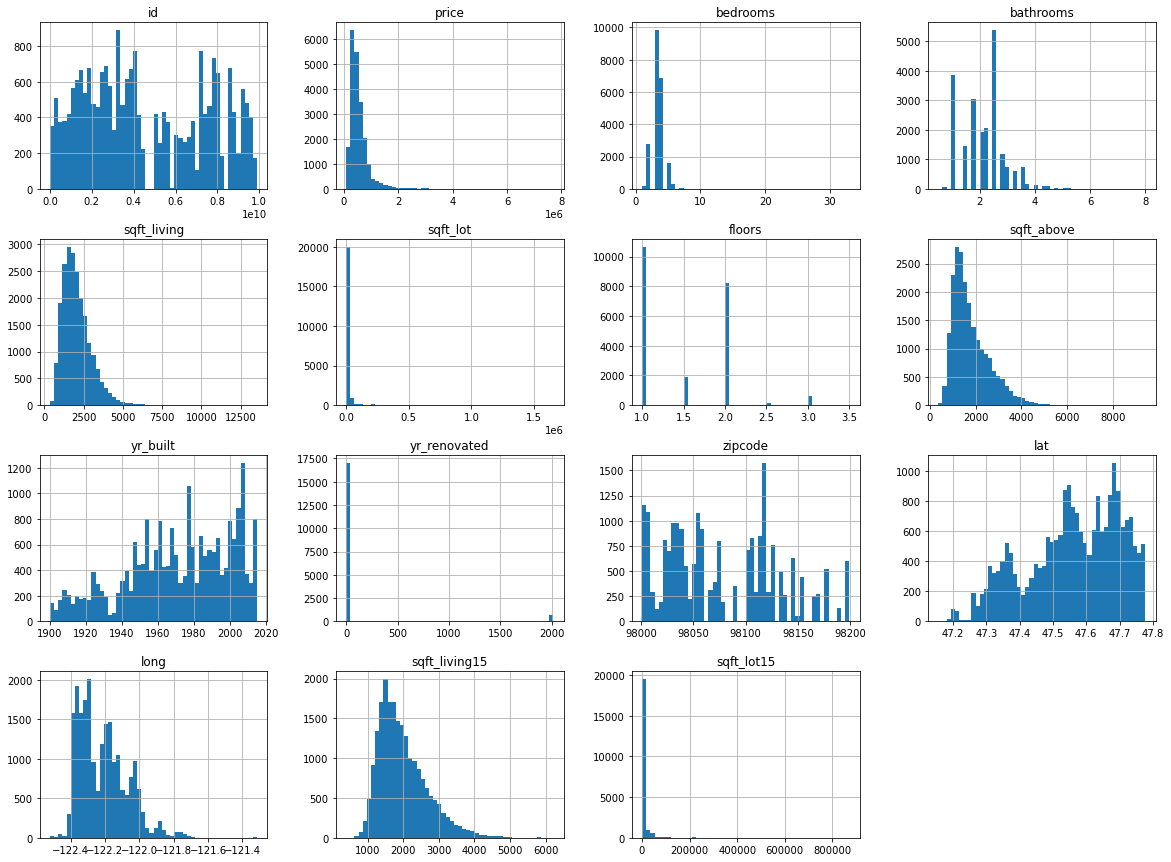

In [3]:
raw_data.hist(bins=50, figsize=(20,15))
plt.show()

Right away we can see some differences in what data we have. 'bedrooms' and 'bathrooms' look to be discrete counts of those home features, as does 'floors'. The features that begin with 'sqft' all look to be continuous, as does 'price'.  'lat' and 'long' are the location data for the home. 'yr_renovated' looks funny because they must use 0 for homes with no renovation. We will dive deeper into each feature in section 3.
______
Since we have latitude and longitude data for our homes, we can also print a quick scatterplot that will function as a map. We have included a color palate based on price to see if that gives us any clues about price density

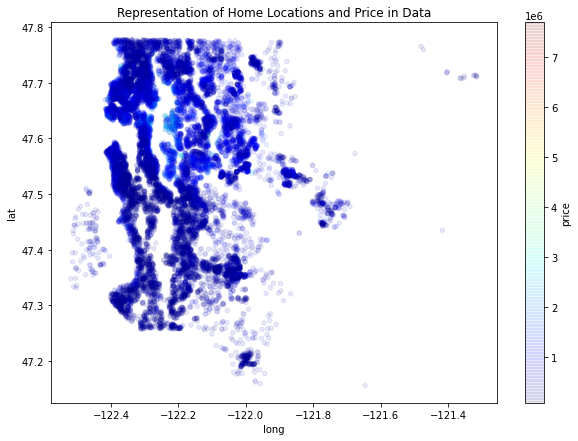

In [4]:
raw_data.plot(kind='scatter', x='long', y='lat', alpha=0.09, figsize=(10,7),
             c='price', cmap=plt.get_cmap('jet'), colorbar=True,
             sharex=False)
plt.title('Representation of Home Locations and Price in Data');

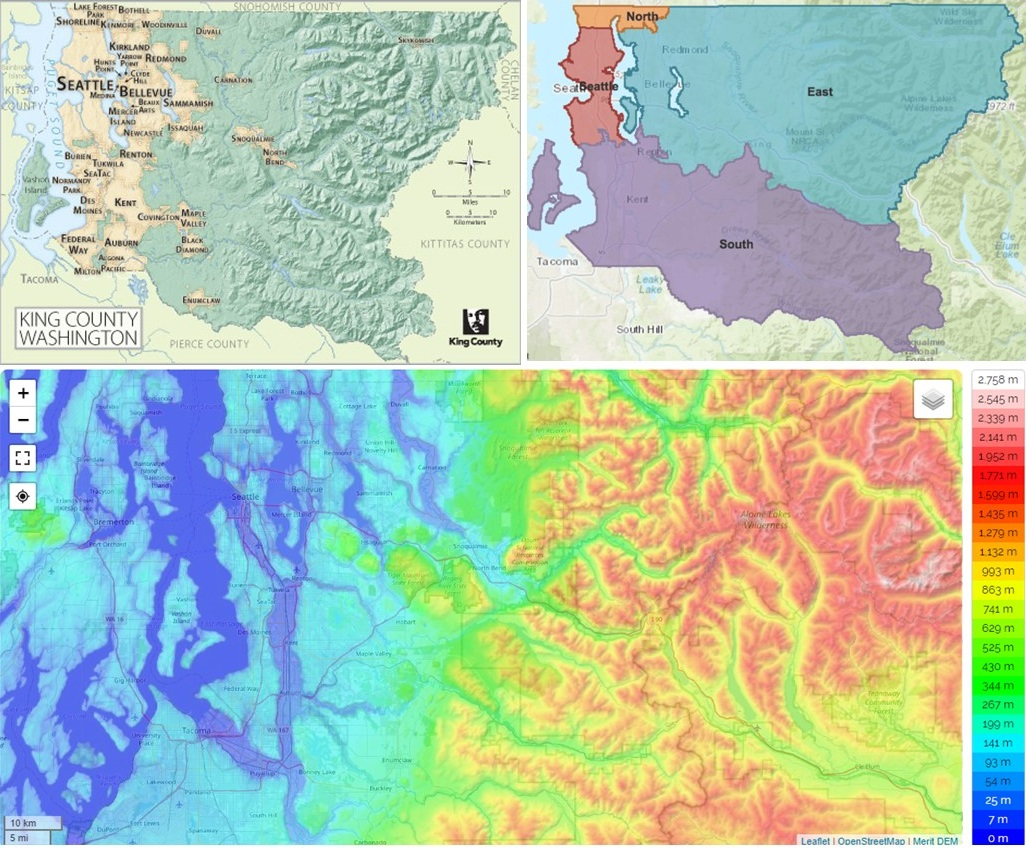

In [5]:
from IPython.display import Image
Image(filename='images\king_co_maps.jpg')

We can see that our homes in the dataset follow the topography and water features of the map of the county. You can also see the smaller towns east and southeast of Seattle, as well as Skykomish in the top right of the scatterplot, and Vashon island (the light cluster on the left edge, middle).

It looks like the more expensive homes are all in the Seattle area, which makes sense as it's a large, metropolitan area.

Research shows that King County is generally divided into four major regions:
- Seattle
- North
- South
- East

The north region is quite small compared to the other three. Looking at google maps, we can see continuing suburban sprawl north of the county line where the 'north' region is.  The geography of the eastern portions of both of the 'south' and 'east' regions does not support much development.

We may want to consider using region information as we continue modeling.
________
Our modeling target it the price of a home, so we can use a correlation matrix to identify features that correlate with 'price'

In [6]:
corr_matrix = raw_data.corr()
corr_matrix['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
bedrooms         0.308787
lat              0.306692
floors           0.256804
yr_renovated     0.129599
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
long             0.022036
id              -0.016772
zipcode         -0.053402
Name: price, dtype: float64

Initial correlation results do not represent all features yet, there are still categorical features to convert.

**High correlation** (corr coefficient > 0.7)
- 'sqft_living', which makes a lot of sense. While the total square footage isn't the only feature of a home, it is a strong predictor of price.

**Moderate correlation** (corr coefficient > 0.5):

- 'sqft_above' which makes sense in exactly the same way as 'sqft_living'. The documentation with the data says this is the square footage of the home minus any basement space. There is likely some multicollinearity here with 'sqft_living'

- 'sqft_living15' is the average square footage of the 15 nearest homes to the home in question. Generally neighborhoods see similar sized homes within them, so it makes sense that if the square footage of a home is correlated with the price, and surrounding homes are similar in size, then that value would also correlate.

- 'bathrooms' makes sense in relationship to price. As homes get bigger, there is a greater need for bathrooms, and those homes likely are more expensive. There may be multicollinearity here too.

**Low correlation** (corr coefficient > 0.3):

- 'bedrooms' makes sense in the same way that bathrooms does, but it's likely that bathrooms are more important to value because they represent a universal need for both home residents and guests. There are sometimes bathrooms assigned for use by guests that are not used by residents. Bedrooms on the other hand almost solely exist for use by the residents. Also curious about multicollinearity here.

- 'Lat' also makes sense, with a much higher correlation than 'long'. Most of the homes are north and south along the east side of the Puget Sound, which is the western border of the county. Very few homes to the east part of the county due to mountains and rivers.

**Negligible correlation** (corr coefficient < 0.3):

- 'floors' will need to be investigated to figure out how to use the data more effectively

- 'yr_renovated' likely will not be included as raw data, but will need to engineer additional features derived from them.

- Below that we see the 'sqft_lot' and 'sqft_lot15'. We will look more closely at this, but these features on their own don't seem that interesting. It makes sense because a large lot does not guarantee a home with a high price.

- 'yr_built' on its own it may not be interesting, but we may use it to engineer other features.

- 'id' is a unique identifier used from the data collection, it makes sense there is no correlation there.

- Also 'zipcode', even though it's numerical in value, is categorical in nature, so it also makes sense that there is no correlation.

**Features which did not represent in the matrix due to being categorical**:
- 'date'
- 'waterfront'
- 'view'
- 'condition'
- 'grade'
- 'sqft_basement' <<< suspicious, should be numerical
_____________
We will leave the raw data from import just in case we need to return to it, and make a copy to use moving forward.


In [7]:
df = raw_data.copy()

In [8]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Home data shows the **AVERAGE**:
- Sale price: \\$540,296
- Bedrooms: 3.37
- Bathrooms: 2.11
- Sqft_living: 2,080
- Sqft_lot: 15,099
- Floors: 1.49
- Sqft_above: 1,788
- Year built: 1970

# Feature investigation

As we investigate each feature, there are likely ones that we will not use in modeling at all. We will keep a **running list** of features to drop, that way the feature stays in our dataframe but gets dropped from the predictors before modeling. Important for feature engineering later.

## 'id'

Though we won't be using it in any analysis, keeping the unique identifier may come in handy later if we are dropping some data or our feature engineering gets complex and we need to merge data back together.

In [9]:
features_to_drop = ['id']

## 'date'

First we will convert the column to a datetime object, which will make it easy to engineer other features based on the relationship to sale date.

In [10]:
df.date = pd.to_datetime(df.date)

In [11]:
df.date.describe(datetime_is_numeric=True)

count                            21597
mean     2014-10-29 04:20:38.171968512
min                2014-05-02 00:00:00
25%                2014-07-22 00:00:00
50%                2014-10-16 00:00:00
75%                2015-02-17 00:00:00
max                2015-05-27 00:00:00
Name: date, dtype: object

The sale dates range from 5/2/2014 to 5/27/2015.

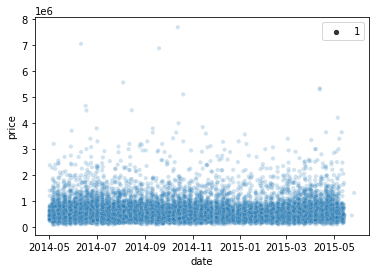

In [12]:
sns.scatterplot(data=df, x='date', y='price', size=1, alpha=0.2);

There, unsuprisingly, does not seem to be any linear relationship between sale date and price. But again, we may want to use the sale date information to engineer new features.

In [13]:
features_to_drop.extend(['date'])

## 'price' **(TARGET)**

In [14]:
df.price.describe().round()

count      21597.0
mean      540297.0
std       367368.0
min        78000.0
25%       322000.0
50%       450000.0
75%       645000.0
max      7700000.0
Name: price, dtype: float64

The average home price in our dataset is \\$540,297 but if you look at the 50th percentile it's significantly lower at \\$450,000. We also definitely have some mansions in our data, our max price is $7.7 million

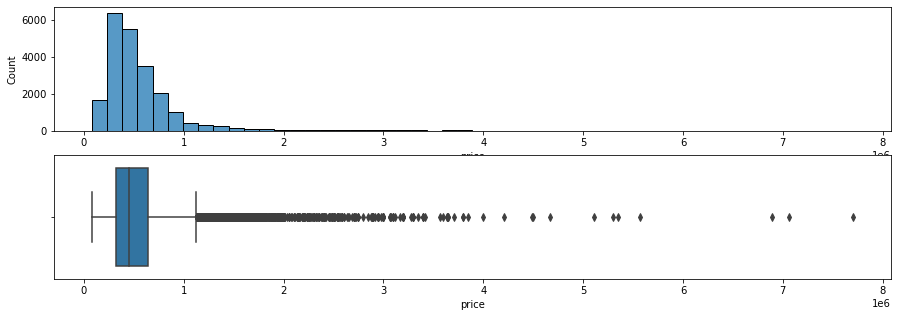

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,5))
sns.histplot(data=df, x='price', bins=50, ax=ax[0])
sns.boxplot(data=df, x='price', ax=ax[1]);

In [16]:
upper_limit_price = df.price.mean() + 3*df.price.std()
upper_limit_price

1642400.9938097603

If we define outliers as more than 3x the standard deviation away from the mean, then outliers are considered homes over $1,642,401

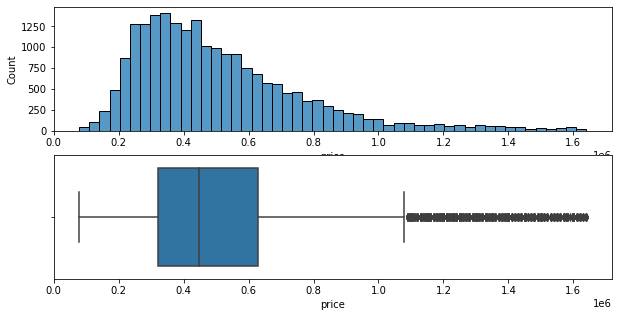

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5))
sns.histplot(data=df[df.price<upper_limit_price], x='price', bins=50,
             ax=ax[0])
sns.boxplot(data=df[df.price<upper_limit_price], x='price', ax=ax[1]);

In [18]:
df[df.price<upper_limit_price].describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.119100e+04,2.119100e+04,21191.000000,21191.000000,21191.000000,2.119100e+04,21191.000000,21191.000000,21191.000000,17425.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000
mean,4.592327e+09,5.070103e+05,3.356095,2.087514,2032.486103,1.482673e+04,1.486858,1751.498938,1970.926525,79.373142,98078.289651,47.558989,-122.213732,1960.388656,12631.720589
std,2.878225e+09,2.594622e+05,0.917527,0.736021,836.738586,4.040095e+04,0.538297,772.205310,29.285262,390.038728,53.407481,0.139455,0.141433,655.151335,27193.757002
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.125400e+09,3.200000e+05,3.000000,1.500000,1410.000000,5.005500e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.467050,-122.329000,1480.000000,5080.000000
50%,3.905040e+09,4.470000e+05,3.000000,2.250000,1890.000000,7.560000e+03,1.000000,1544.000000,1975.000000,0.000000,98065.000000,47.569900,-122.231000,1820.000000,7576.000000
75%,7.334500e+09,6.276500e+05,4.000000,2.500000,2500.000000,1.049050e+04,2.000000,2170.000000,1996.000000,0.000000,98118.000000,47.678800,-122.124000,2330.000000,10000.000000
max,9.900000e+09,1.640000e+06,33.000000,7.500000,7480.000000,1.651359e+06,3.500000,7320.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,871200.000000


With outliers removed the features averages are still pretty similar with one difference: the price. It's dropped from \\$540k to \\$507k USD

In [19]:
price_outliers_df = df[df.price>upper_limit_price]

In [20]:
price_outliers_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,4.060000e+02,4.060000e+02,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,330.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,3.961826e+09,2.277660e+06,4.266010,3.593596,4577.088670,29331.751232,1.871921,3724.906404,1974.817734,308.769697,98060.320197,47.617712,-122.227039,3355.770936,19364.182266
std,2.730670e+09,7.683480e+05,0.944472,0.978400,1395.281825,76438.853377,0.473599,1227.548725,33.560136,723.297575,56.069630,0.052030,0.095943,815.442995,30513.711245
min,4.610035e+07,1.650000e+06,2.000000,1.750000,2360.000000,1880.000000,1.000000,1520.000000,1900.000000,0.000000,98004.000000,47.416900,-122.416000,1490.000000,2199.000000
25%,1.652500e+09,1.792500e+06,4.000000,3.000000,3715.000000,8864.500000,2.000000,2880.000000,1950.000000,0.000000,98006.000000,47.582975,-122.284000,2870.000000,8557.250000
50%,3.528000e+09,2.000000e+06,4.000000,3.500000,4325.000000,14754.000000,2.000000,3590.000000,1988.000000,0.000000,98040.000000,47.625900,-122.223500,3290.000000,13224.500000
75%,5.663328e+09,2.497500e+06,5.000000,4.250000,5150.000000,21241.000000,2.000000,4320.000000,2004.000000,0.000000,98112.000000,47.639725,-122.202000,3847.500000,19273.250000
max,9.831200e+09,7.700000e+06,8.000000,8.000000,13540.000000,920423.000000,3.500000,9410.000000,2015.000000,2014.000000,98199.000000,47.762400,-121.756000,6210.000000,411962.000000


- There are 406 homes in our dataset that meet this definition of outlier. 
- These homes average \\$2.2 million USD
- They have on average 4 bedrooms and 3.5 baths
- They are also on average about 4,570 ft$^{2}$


Baseline modeling we will use everything, but this is one option for restricting our dataset to improve modeling. 

We may need to consider scaling and normalizing also.
_______________
'price' is the target variable for our model, so we will add this to the features to drop list.

In [21]:
features_to_drop.extend(['price'])

## 'bedrooms'


In [22]:
df.bedrooms.describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

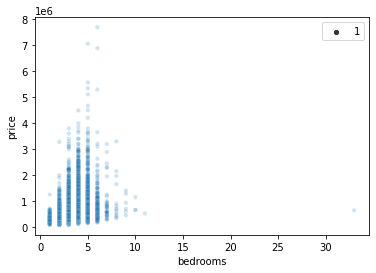

In [23]:
sns.scatterplot(data=df, x='bedrooms', y='price', alpha=0.2, size=1);

In [24]:
df[df.bedrooms == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,NO,NONE,...,7 Average,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


This outlier in number of bedrooms is interesting. I doubt very much there are 33 bedrooms in a 1,600 ft$^{2}$ home. We suspect an entry error and are going change it to 3, which is much more likely.

In [25]:
df.at[15856,'bedrooms'] = 3

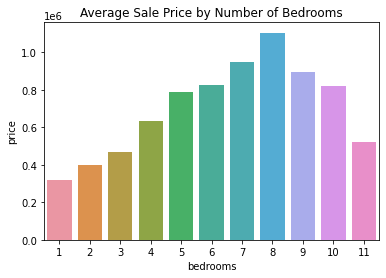

In [26]:
bedrooms_df = df.groupby('bedrooms').mean()[['price']]
bedrooms_df.reset_index(inplace=True)
sns.barplot(data=bedrooms_df, x='bedrooms', y='price')
plt.title('Average Sale Price by Number of Bedrooms');

In [27]:
df.bedrooms.value_counts()

3     9825
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

It looks like there are only 10 homes out of over 21,000 that have more than 8 bedrooms, and only 61 homes that have over 6 bedrooms.

>After baseline modeling it may be something to consider dropping all homes over 6 bedrooms to see if the model improves. The model will do a worse job at predicting larger homes like mansions, but will be better at predicting the majority of more normal homes.

## 'bathrooms'

In [28]:
df.bathrooms.describe()

count    21597.000000
mean         2.115826
std          0.768984
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64

In [29]:
df.bathrooms.value_counts().sort_index()

0.50       4
0.75      71
1.00    3851
1.25       9
1.50    1445
1.75    3048
2.00    1930
2.25    2047
2.50    5377
2.75    1185
3.00     753
3.25     589
3.50     731
3.75     155
4.00     136
4.25      79
4.50     100
4.75      23
5.00      21
5.25      13
5.50      10
5.75       4
6.00       6
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
8.00       2
Name: bathrooms, dtype: int64

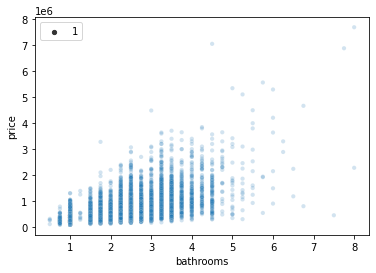

In [30]:
sns.scatterplot(data=df, x='bathrooms', y='price', alpha=0.2, size=1);

The range of values was unexpected. 

After some research, learned that a bathroom is considered 'full' with 4 parts, each worth a quarter:
- sink
- toilet
- shower
- bathtub


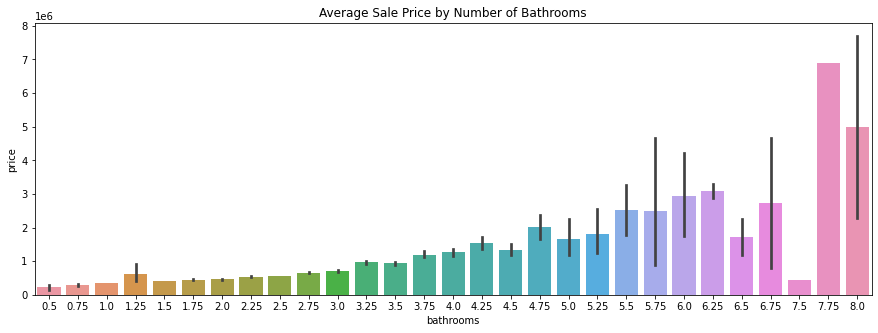

In [31]:
fig = plt.subplots(figsize=(15,5))
sns.barplot(data=df, x='bathrooms', y='price')
plt.title('Average Sale Price by Number of Bathrooms');

Things fall apart in the relationship between bathroom count and price average. If you look at the value counts above you see that each count of bathrooms equal to or greater than 5.5 is represented by 10 or less homes.

In fact, homes with more than 4 bathrooms account for only 266 entries in our dataframe, about 1.2%.

In [32]:
bathrooms_df = df[['price', 'bathrooms']].copy()

Because the 'bathrooms' feature is the total bathrooms in the home, and each bathroom is represented as a quarter-step percentage, it's difficult to know the actual makeup of the bathrooms in the home.
> 2.5 bathrooms is our most frequent value. The makeup of that number could be:
> - 10 quarter baths
> - 8 quarters and a half bath
> - 7 quarters and a 3/4 bath
> - 6 quarters and 2 half baths
> - 6 quarters and a full bath
> - 5 quarters, a 3/4 bath and a half bath
> - 4 quarters and two 3/4 bath
> - 4 quarters, a half, and a full
> - 3 quarters, a 3/4 bath and a full
> - 2 quarters and 4 half baths
> - 2 quarters, 2 half baths, and a whole
> - 2 quarters, two 3/4
> - 1 quarter and 3 3/4 baths
> - 2 half bath and two 3/4 bath
> - 2 half bath and two full bath


If we round each bathroom count up to the next whole number, we may be able to have a better approximation of the number of bathrooms in the home, regardless of what constitutes each bathroom.

The average value for bathrooms from the entire dataset is 2.11, which if we rounded up would be 3 baths.

Also this is a feature that may be able to be related to 'sqft_living' to engineer new features that may be more interesting. We could also use the count of bathrooms and bedrooms to get an average room size for the home, which may also be interesting.

In [33]:
import math

bathrooms_df['bathrooms'] = bathrooms_df.bathrooms.map(lambda x: math.ceil(x))

In [34]:
bathrooms_df.bathrooms.value_counts().sort_index()

1    3926
2    6432
3    9362
4    1611
5     223
6      33
7       6
8       4
Name: bathrooms, dtype: int64

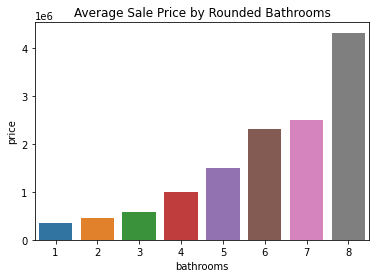

In [35]:
bathrooms_df = bathrooms_df.groupby('bathrooms').mean()[['price']]
bathrooms_df.reset_index(inplace=True)
sns.barplot(data=bathrooms_df, x='bathrooms', y='price')
plt.title('Average Sale Price by Rounded Bathrooms');

We've only got 43 homes that represent bathroom counts of 6, 7, and 8. This is what drive the average up so high for those values, you can see this when you look at the scatter plot above as well.

After baseline modeling we may consider rounding and/or dropping some homes based on number of bathrooms.

## 'sqft_living'

In [36]:
df.sqft_living.describe()

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

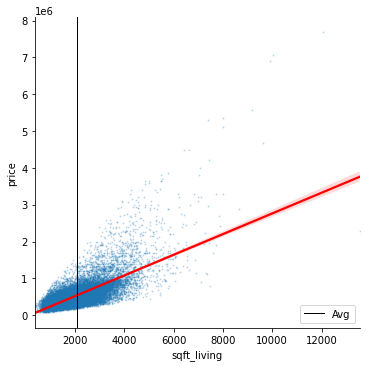

In [37]:
sns.lmplot(data=df, x='sqft_living', y='price', line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=df.sqft_living.mean(), color='black', lw=1, label='Avg')
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.legend();

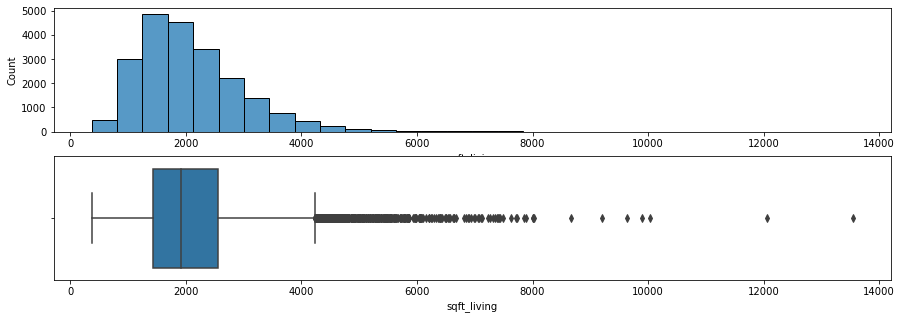

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,5))
sns.histplot(data=df, x='sqft_living', bins=30, ax=ax[0])
sns.boxplot(data=df, x='sqft_living', ax=ax[1]);

In [39]:
upper_limit_sqft_living = df.sqft_living.mean() + 3*df.sqft_living.std()
upper_limit_sqft_living

4834.640225497227

The price data is skewed, looks like we have lots of large homes in our dataset

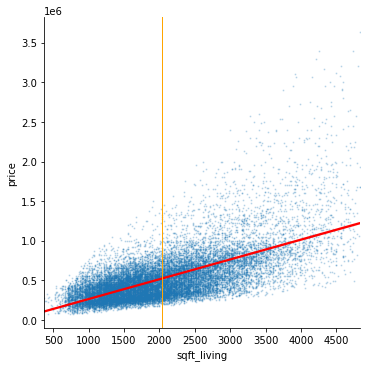

In [40]:
sns.lmplot(data=df[df.sqft_living<upper_limit_sqft_living], x='sqft_living',
           y='price', line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=df[df.sqft_living<upper_limit_sqft_living].sqft_living.mean(),
            color='orange', lw=1)
plt.ticklabel_format(style='plain', axis='x',useOffset=False);

Even removing outliers it's clear that it gets more difficult to predict price as the square footage gets large. There are certainly other factors responsible.

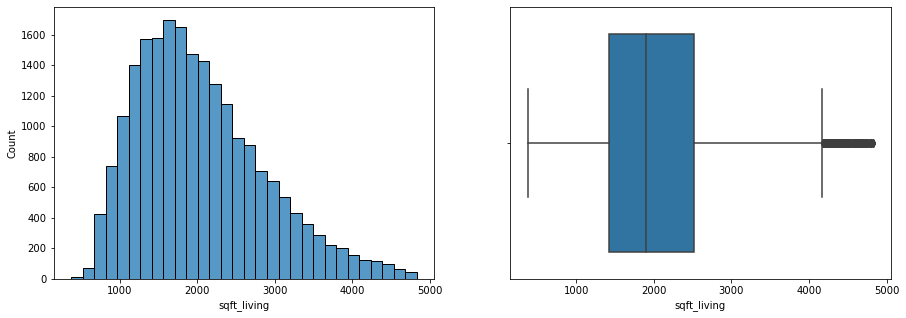

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.histplot(data=df[df.sqft_living<upper_limit_sqft_living], x='sqft_living',
             bins=30, ax=ax[0])
sns.boxplot(data=df[df.sqft_living<upper_limit_sqft_living], x='sqft_living',
            ax=ax[1]);

In [42]:
df[df.sqft_living<upper_limit_sqft_living].describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.134900e+04,2.134900e+04,21349.000000,21349.000000,21349.000000,2.134900e+04,21349.000000,21349.000000,21349.000000,17551.000000,21349.000000,21349.000000,21349.000000,21349.000000,21349.000000
mean,4.583236e+09,5.235488e+05,3.357253,2.092264,2036.837182,1.464966e+04,1.488688,1755.366715,1970.796056,83.469033,98078.256171,47.559795,-122.214729,1966.775634,12431.305354
std,2.876796e+09,3.122114e+05,0.893689,0.733955,820.674600,3.999190e+04,0.538586,762.723544,29.343347,399.556272,53.507426,0.138961,0.140686,656.618177,25510.449235
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123700e+09,3.200000e+05,3.000000,1.500000,1420.000000,5.021000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.469500,-122.329000,1480.000000,5098.000000
50%,3.904940e+09,4.499500e+05,3.000000,2.250000,1900.000000,7.561000e+03,1.500000,1550.000000,1974.000000,0.000000,98065.000000,47.571600,-122.232000,1830.000000,7592.000000
75%,7.312400e+09,6.350000e+05,4.000000,2.500000,2520.000000,1.050000e+04,2.000000,2180.000000,1996.000000,0.000000,98118.000000,47.678400,-122.126000,2340.000000,10000.000000
max,9.900000e+09,3.640000e+06,11.000000,7.500000,4830.000000,1.651359e+06,3.500000,4830.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,560617.000000


In [43]:
sqft_living_outliers_df = df[df.sqft_living>upper_limit_sqft_living]
sqft_living_outliers_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.480000e+02,2.480000e+02,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,204.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,4.342769e+09,1.982025e+06,4.625000,4.144153,5823.685484,53815.677419,1.959677,4649.201613,1988.528226,98.068627,98051.754032,47.585771,-122.149730,3694.943548,40906.092742
std,2.867339e+09,1.124242e+06,0.917939,0.982455,1120.504588,100972.182168,0.417709,1147.377001,26.760885,433.012480,47.226733,0.093724,0.128806,908.584661,89385.480918
min,4.610035e+07,4.520000e+05,2.000000,1.750000,4850.000000,4600.000000,1.000000,2560.000000,1904.000000,0.000000,98001.000000,47.263000,-122.412000,1280.000000,4080.000000
25%,1.925817e+09,1.240000e+06,4.000000,3.500000,5127.500000,12961.250000,2.000000,3805.000000,1984.000000,0.000000,98006.000000,47.546375,-122.233000,3037.500000,11063.000000
50%,3.757801e+09,1.680000e+06,4.500000,4.000000,5480.000000,20292.500000,2.000000,4495.000000,1999.000000,0.000000,98040.000000,47.592650,-122.151000,3700.000000,15755.500000
75%,7.237500e+09,2.472500e+06,5.000000,4.500000,6070.000000,41958.000000,2.000000,5240.000000,2005.000000,0.000000,98074.000000,47.641325,-122.075250,4300.000000,33655.000000
max,9.831200e+09,7.700000e+06,8.000000,8.000000,13540.000000,871200.000000,3.500000,9410.000000,2015.000000,2009.000000,98199.000000,47.766600,-121.764000,6210.000000,871200.000000


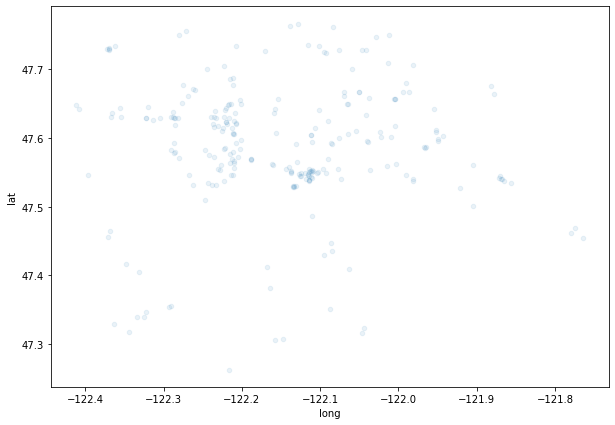

In [44]:
sqft_living_outliers_df.plot(kind='scatter', x='long', y='lat', alpha=0.09,
                          figsize=(10,7));

Plotting the outliers based on square footage shows that they are kind of all over the county. There does seem to be a concentration around Bellevue, and there are more in Seattle but not concentrated in any one neighborhood it seems.
_______
- 57% of homes are have below the average of 2,080 ft$^{2}$.

- 96% of homes are below 4,000 ft$^{2}$.

- Standard calculation shows outliers as any home greater than 4,834 ft$^{2}$

- Outliers constitute 248 homes out of the dataset, have an average sqft_living of 5,823 ft$^{2}$, tend to be newer with a basement, almost 5 bedrooms, 4 bathrooms and sold for an average of just under \\$2 million USD


The vast majority of our sqft_living data is grouped under 4,000 ft$^{2}$. There are some large homes out there, but our mean and median are pretty close (2,080 vs 1,910). The data looks normal except for the right skewedness.


Again, suspect that we have a subset of extremely large homes. This looks like a feature to use to restrict our dataset a bit to maybe improve the model? Maybe viewing large homes represented on a map vs all other sized homes will show neighborhoods that are more likely to hold large homes?

## 'sqft_lot'

In [45]:
df.sqft_lot.describe().round()

count      21597.0
mean       15099.0
std        41413.0
min          520.0
25%         5040.0
50%         7618.0
75%        10685.0
max      1651359.0
Name: sqft_lot, dtype: float64

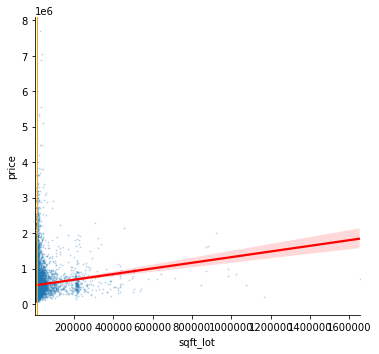

In [46]:
sns.lmplot(data=df, x='sqft_lot', y='price', line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=df.sqft_lot.mean(), color='orange', lw=1)
plt.ticklabel_format(style='plain', axis='x',useOffset=False);

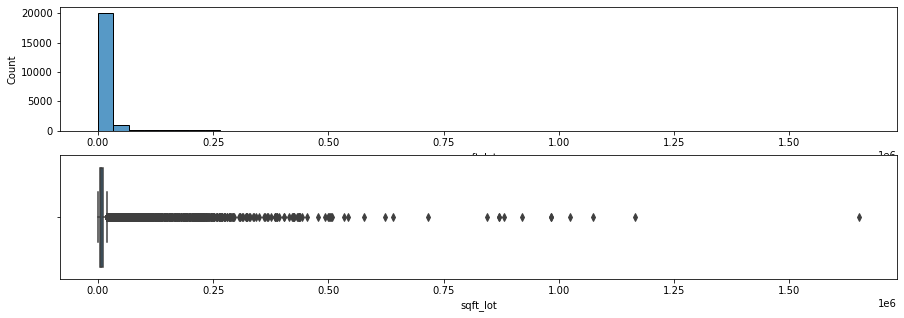

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,5))
sns.histplot(data=df, x='sqft_lot', bins=50, ax=ax[0])
sns.boxplot(data=df, x='sqft_lot', ax=ax[1]);

Even more so that 'sqft_living', the square footage of the lot has a relatively small number of huge outliers.

Three quarters of our data on 'sqft_lot' is under 10,685 ft$^{2}$, but the average lot is about 15,099 ft$^{2}$. The lot sizes are heavily positive skewed. 

In [48]:
# sqft is easy to estimate for inside home size, but more difficult to get a
# sense for. If we later want to conver to acres, divide sqft by 43560

In [49]:
upper_limit_sqft_lot = df.sqft_lot.mean() + 3*df.sqft_lot.std()
print(f'Upper limit for outlier cutoff is:\n-{round(upper_limit_sqft_lot, 2)}\
 ft2, or\n-{round(upper_limit_sqft_lot/43560, 2)} acres')

Upper limit for outlier cutoff is:
-139337.32 ft2, or
-3.2 acres


In [50]:
sqft_lot_outliers_df = df[df.sqft_lot>upper_limit_sqft_lot]
sqft_lot_outliers_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,3.460000e+02,3.460000e+02,346.000000,346.000000,346.000000,3.460000e+02,346.000000,346.000000,346.000000,299.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,2.173847e+09,6.782525e+05,3.419075,2.507948,2890.358382,2.718045e+05,1.586705,2621.731214,1983.549133,86.618729,98043.052023,47.484841,-122.026402,2404.757225,150465.182081
std,1.706962e+09,3.581175e+05,0.904472,0.944152,1405.499739,1.689485e+05,0.494605,1230.521659,22.126492,406.965504,24.875287,0.167551,0.161932,702.414778,107019.943138
min,1.200590e+08,1.500000e+05,1.000000,1.000000,710.000000,1.393920e+05,1.000000,710.000000,1900.000000,0.000000,98001.000000,47.159300,-122.519000,1060.000000,3572.000000
25%,1.020569e+09,4.406250e+05,3.000000,1.750000,1982.500000,1.994248e+05,1.000000,1764.500000,1976.000000,0.000000,98022.000000,47.362400,-122.084750,1915.000000,61854.750000
50%,1.921569e+09,5.850000e+05,3.000000,2.500000,2665.000000,2.178025e+05,2.000000,2450.000000,1990.000000,0.000000,98038.000000,47.456300,-122.010500,2300.000000,150681.500000
75%,2.925822e+09,7.900000e+05,4.000000,3.000000,3460.000000,2.700132e+05,2.000000,3230.000000,2000.000000,0.000000,98063.500000,47.647175,-121.940250,2760.000000,217796.750000
max,9.206700e+09,2.280000e+06,7.000000,8.000000,13540.000000,1.651359e+06,3.000000,9410.000000,2014.000000,2008.000000,98092.000000,47.775400,-121.691000,5610.000000,871200.000000


346 homes would meet the condition of being an outlier in the sqft_lot feature. The average price is higher than that of the full dataset for these outliers
_______________
Lets look at the scatterplot from above with outliers removed.

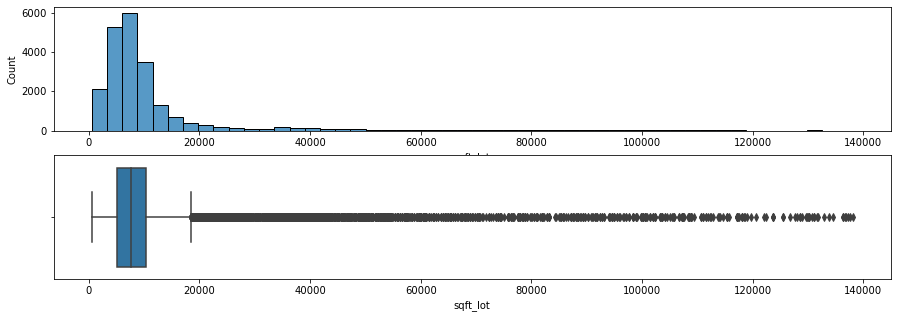

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,5))
sns.histplot(data=df[df.sqft_lot<upper_limit_sqft_lot], x='sqft_lot', bins=50,
             ax=ax[0])
sns.boxplot(data=df[df.sqft_lot<upper_limit_sqft_lot], x='sqft_lot',
            ax=ax[1]);

Still lots of homes considered outliers after removing the 'first round' of ouliers from the raw dataset. The 'sqft_lot' skewness is really bad.
______
Lets scatterplot the outliers and see where they are geographically

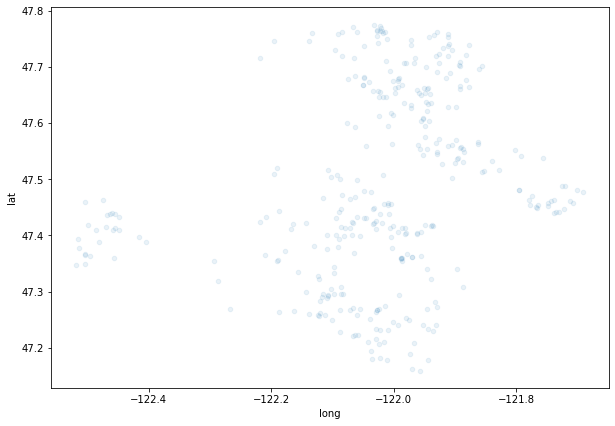

In [52]:
sqft_lot_outliers_df.plot(kind='scatter', x='long', y='lat', alpha=0.09,
                          figsize=(10,7));

You can see Vashon Island represented on the left of the figure, but then most of the larger lots are east and south/east of Seattle.

This figure does not represent the eastern-most section of the county. It appears that Skykomish does not have any homes on lots considered outliers. This makes sense, that part of the county is very mountainous and larger lots are less likely.
_______________

In [53]:
len(df[df.sqft_lot < 15099])/len(df)

0.8519238783164328

The large lot sizes are enormously large in comparison, and that may be fouling up our model later. This is another feature we may need to scale/normalize later on.

85% of homes have a lot less than the average of 15,099 ft$^{2}$. 

Lot size is not a guarantee of high home value. In fact in our first scatter plot, it looks like smaller lot sizes are **more** valuable than larger. Lots do not grow in size proportionately to the home, and larger lots tend to be further from commercial amenities.

> For now we are leaving everything in the baseline model, but this is a feature that may be re-engineered and dropped, as it doesn't share much of a linear relationship with price.

## 'floors'

In [54]:
df.floors.describe()

count    21597.000000
mean         1.494096
std          0.539683
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

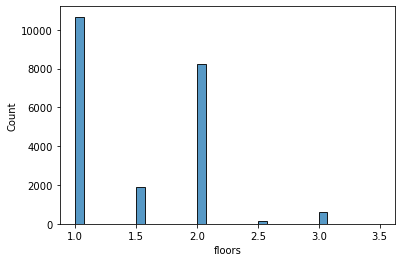

In [55]:
sns.histplot(data=df, x='floors');

In [56]:
df.floors.value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

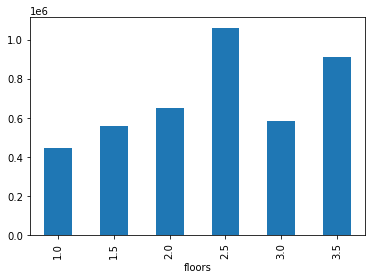

In [57]:
df.groupby('floors').mean()['price'].plot(kind='bar');

It initially looks like the average price increases with each half-floor increase until 2.5 floors, then goes down for 3 floors and back up for 3.5. Looking at the data shows we have a \\$3.3 million mansion with 3.5 floors that affects our average.
________
A half-storey house is a detached home that has an addition floor that is about half the size of the main floor(s), but is off to one side.

Most of our data is 1 or 2 floor homes, but we have some 1.5, 2.5, 3 and 3.5 in there too.

The relationship between average price and number of floors increases until 2.5 floors, decreases


>During initial EDA we saw that there was not much correlation between price and floors. One idea is to change this into a boolean for more than 1 floor, with 1 being if it's 1.5 and above and 0 being 1 floor. For baseline modeling we will leave it in.

>It could also be the case that by looking at the square footage divided by the floors we can get an idea of the footprint of the home, which may show that many of our multi-floor homes are actually townhomes.

## 'waterfront'

In importing we checked for null values, and there were some in the 'waterfront' feature.

In [58]:
df.waterfront.value_counts(normalize=True)

NO     0.992404
YES    0.007596
Name: waterfront, dtype: float64

There are only two options, waterfront or not. Less than 1% of homes are waterfront, so we assume that no value means no waterfront view, and set the value to 'NO'.

In [59]:
df['waterfront'].fillna('NO', inplace=True)

This is a simple categorical, if the home is considered waterfront or not. 

We will convert this to a numerical feature, YES being 1 and NO being 0.

In [60]:
# converted 'waterfront' feature (numeric boolean)
df['waterfront'] = df.waterfront.map({'NO': 0, 'YES': 1})

In [61]:
df.groupby('waterfront').mean()['price']

waterfront
0    5.322862e+05
1    1.717215e+06
Name: price, dtype: float64

Waterfront properties have, on average, 3x the value of properties that are not waterfront. This seems like a good predictor given the amount of waterfront property in the county.

## 'view'

In checking for null values, we also have some in the 'view' feature.

In [62]:
df.view.value_counts(normalize=True)

NONE         0.901923
AVERAGE      0.044441
GOOD         0.023591
FAIR         0.015325
EXCELLENT    0.014721
Name: view, dtype: float64

The values are categorical, and over 90% of homes have a view value of 'NONE'. The 63 missing values will be set to 'NONE'.

In [63]:
df['view'].fillna('NONE', inplace=True)

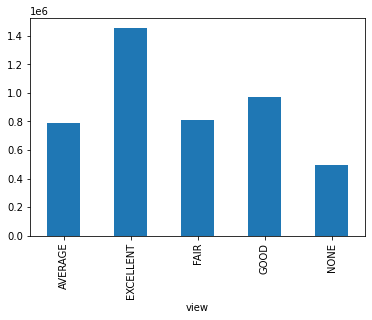

In [64]:
df.groupby('view').mean()['price'].plot(kind='bar');

The documentation describes this as the quality of view from a house. It will need to be converted to model.

Comparing the categories shows an increase in average price for a home as the quality of the view increases. However, 'fair' seems to be a bit higher on average than 'average' view.

One option is onehotencoding this feature, but 90% of this feature is 'NONE' (for no view), so we will convert this to a numerical boolean feature of 1 for having a view and 0 for not having a view.

In [65]:
# converted 'view' feature (numeric boolean)
df['has_view'] = df.view.map(lambda x: 0 if x == 'NONE' else 1)

In [66]:
df.groupby('has_view').mean()['price']

has_view
0    497210.714396
1    937800.344697
Name: price, dtype: float64

Properties that have any view, on average, almost double the value of properties that have no view. This seems like a better predictor for price.

In [67]:
features_to_drop.extend(['view'])

## 'condition'

Documentation with the dataset explains this feature is the overall condition of the home relative to ongoing maintenance.

In [68]:
df.condition.value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

Referencing the documentation, the condition can be graded numerically:

{'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1}

We will need to convert this column before modeling.

In [69]:
# converted 'condition' feature
condition_dict = {'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2,
                  'Poor': 1}
df['condition'] = df.condition.map(condition_dict)

In [70]:
df.condition.describe()

count    21597.000000
mean         3.409825
std          0.650546
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64

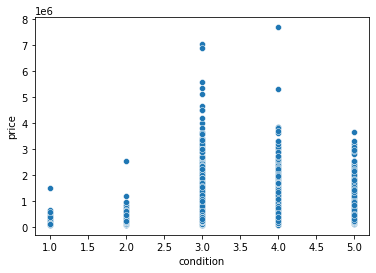

In [71]:
sns.scatterplot(data=df, x='condition', y='price');

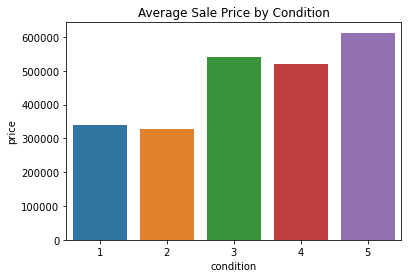

In [72]:
condition_df = df.groupby('condition').mean()[['price']]
condition_df.reset_index(inplace=True)
sns.barplot(data=condition_df, x='condition', y='price')
plt.title('Average Sale Price by Condition');

>Still trying to decide how to deal with this feature after baseline model. Staircase coding? One hot encoding? It seems there is no difference in average price for homes in condition 1 or 2, and little difference between 3 and 4. The difference between the average of 1 and 2 compared to the average of condition 5 is very large though. One other idea is to make the feature 'excellent_condition' and have a boolean 1 if it is or 0 if not, then drop the original condition feature.

## 'grade'

In [73]:
df.grade.value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

We will need to convert the column before encoding, we can just slice the string and take the first section, convert to numerical.

In [74]:
df['grade'] = df.grade.map(lambda x: x.split()[0]).astype('int')

In [ ]:
list(zip(list(df[df.grade==3].columns),list(df[df.grade == 3].values[0])))

Looking at our lonely grade 3 entry shows a well taken care of 1 bedroom very small home built in 1920, so it makes sense that the quality of construction/design is not great. This is a pre-Great Depression home, and a little research shows that the town it's in (Enumclaw) was not incorporated until 1913, so this home is quite old for the town.

In [77]:
df[df.yr_built == 1920]['grade'].value_counts()

7    54
6    26
8    10
5     6
3     1
4     1
Name: grade, dtype: int64

In [79]:
df.groupby('grade').mean()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,has_view
grade,,,,,,,,,,,,,,,,,,
3,2.420069e+09,2.620000e+05,1.000000,0.750000,520.000000,12981.000000,1.000000,0.000000,5.000000,520.000000,1920.000000,0.000000,98022.000000,47.208200,-121.995000,1340.000000,12233.000000,0.000000
4,4.344409e+09,2.120019e+05,1.592593,0.907407,680.740741,15614.777778,1.037037,0.000000,3.148148,673.333333,1936.259259,110.000000,98068.629630,47.496170,-122.165148,1486.666667,12896.629630,0.111111
5,3.887594e+09,2.485240e+05,2.388430,1.113636,983.326446,24019.909091,1.086777,0.016529,3.491736,944.607438,1935.454545,42.057895,98082.694215,47.499478,-122.199331,1380.570248,16122.433884,0.053719
6,4.442552e+09,3.019166e+05,2.685967,1.243499,1191.561335,12646.953876,1.108685,0.004907,3.539745,1068.647694,1942.471050,86.265318,98102.624632,47.533117,-122.262484,1389.247301,11020.924926,0.040726
7,4.527336e+09,4.025946e+05,3.254736,1.829953,1689.514932,11769.877089,1.296802,0.002340,3.491420,1408.425006,1963.615110,74.706601,98082.412525,47.553433,-122.232881,1679.280254,10615.995988,0.047248
8,4.775134e+09,5.429868e+05,3.481616,2.348928,2184.803627,13514.009068,1.667848,0.005276,3.355647,1867.309810,1980.393899,88.236510,98073.445837,47.565931,-122.208003,2067.075845,11371.257049,0.107832
9,4.651166e+09,7.737382e+05,3.773231,2.664340,2868.139962,20638.515488,1.849140,0.008413,3.266157,2554.395411,1988.419120,102.088235,98065.300574,47.575822,-122.165836,2613.460038,17401.707839,0.172849
10,4.404626e+09,1.072347e+06,3.907407,3.006393,3520.299824,28191.063492,1.892857,0.024691,3.232804,3112.086420,1989.569665,87.966774,98061.300705,47.590851,-122.151960,3036.892416,21334.663139,0.241623
11,4.164541e+09,1.497792e+06,4.160401,3.501880,4395.448622,38372.789474,1.961153,0.047619,3.195489,3853.182957,1992.145363,79.598160,98055.255639,47.599853,-122.150554,3532.110276,27743.160401,0.388471


In [80]:
df.grade.describe()

count    21597.000000
mean         7.657915
std          1.173200
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

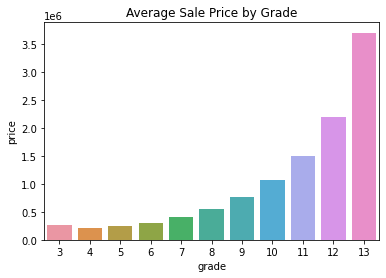

In [81]:
grade_df = df.groupby('grade').mean()[['price']]
grade_df.reset_index(inplace=True)
sns.barplot(data=grade_df, x='grade', y='price')
plt.title('Average Sale Price by Grade');

This feature, per the documentation, is the overall grade of the home relative to construction/design. This is a separate feature than condition, but we will have to see if there is any multicollinearity here. It could certainly be the case that a high graded home (good quality construction or design) could be left to disrepair and have a poor condition value.

>We will leave this as a ordinal feature for now, but it looks like we don't have any serious differences in average price until the middle grades 7 and 8. 

In [ ]:
# # import OneHotEncoder
# from sklearn.preprocessing import OneHotEncoder

# # create temporary dataframe df_test with condition and grade features in it
# # df_test = df[['condition', 'grade']].copy()

# # create temporary dataframe df_test with grade feature in it
# df_test = df[['grade']].copy()

# # create a onehotencoder, fit to df_test
# ohe = OneHotEncoder().fit(df_test)

# # create the array
# onehotarray = ohe.transform(df_test).toarray()

# # generate column_names to match values, 'feature_{value}'
# column_names = []
# # for x in range(1,6):
# #     column_names.append(f'condition_{x}')
# for x in range(1,11):
#     column_names.append(f'grade_{x}')
    
# # create dataframe of array with correct column names
# ohe_df = pd.DataFrame(onehotarray, columns=column_names)

# # remove the column representing feature average from the dataframe
# ohe_df.drop(['condition_3', 'grade_4'], axis=1, inplace=True)

# # concat the main dataframe df with the onehotencoded df we just made
# df = pd.concat([df, ohe_df], axis=1)

# # add the original two features to the list of features to drop
# features_to_drop.extend(['condition', 'grade'])

# # df.drop(['condition', 'grade'], axis=1, inplace=True)

## 'sqft_above'

This is the square footage of the home apart from the basement. There is likely some multicollinearity with other features like 'sqft_living', and 'sqft_basement'.

In [82]:
df.sqft_above.describe()

count    21597.000000
mean      1788.596842
std        827.759761
min        370.000000
25%       1190.000000
50%       1560.000000
75%       2210.000000
max       9410.000000
Name: sqft_above, dtype: float64

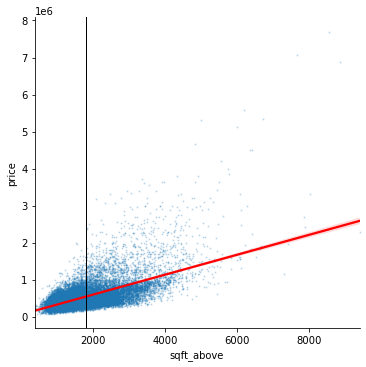

In [85]:
sns.lmplot(data=df, x='sqft_above', y='price', line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=df.sqft_above.mean(), color='black', lw=1, label='Avg')
plt.ticklabel_format(style='plain', axis='x',useOffset=False);

In [86]:
len(df[df.sqft_living == df.sqft_above]) / len(df)

0.6070287539936102

If we consider below that 60% of homes have no basement, then the relationship between 'sqft_living' and 'sqft_above' is likely very strong and probably experience high multicollinearity.

>We will likely drop this raw feature from modeling to reduce multicollinearity, but will likely use it to engineer different features.


## 'sqft_basement'

In [87]:
df.sqft_basement.value_counts(normalize=True)

0.0       0.593879
?         0.021021
600.0     0.010048
500.0     0.009677
700.0     0.009631
            ...   
861.0     0.000046
1960.0    0.000046
588.0     0.000046
768.0     0.000046
906.0     0.000046
Name: sqft_basement, Length: 304, dtype: float64

First, we need to address that not all of the values are numerical. 59% of the homes have 0.0 for basement square footage, meaning there is no basement. 2% of homes have a '?' value. We are going to assume that these question marks are also 0.0 values, that way we can have a numerical column.

In [88]:
df.sqft_basement.replace(to_replace='?', value=0.0, inplace=True)
df['sqft_basement'] = df.sqft_basement.astype('float')

In [96]:
df_hasbasement = df[df.sqft_basement > 0]
df_hasbasement.describe()['sqft_basement']

count    8317.000000
mean      741.928700
std       404.765113
min        10.000000
25%       450.000000
50%       700.000000
75%       980.000000
max      4820.000000
Name: sqft_basement, dtype: float64

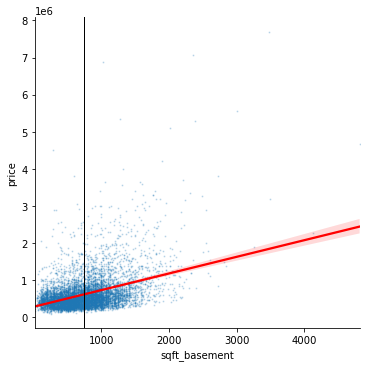

In [101]:
sns.lmplot(data=df_hasbasement, x='sqft_basement', y='price',
           line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=df_hasbasement.sqft_basement.mean(), color='black', lw=1,
            label='Avg')
plt.ticklabel_format(style='plain', axis='x',useOffset=False);

It's unclear if there will be multicollinearity with this feature or not. 40% of homes have basements, and those basements range from 10 to 4,800 ft$^{2}$.

It seems more likely that to include this feature we may need to engineer it as a numeric boolean for if the property has a basement or not, or perhaps bin the values in some way.

## 'yr_built'

In [102]:
df.yr_built.describe()

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

Homes in our data were built between 1900 and 2015. Considering another feature is renovations and that is part of our business problem, it will be important to see the relationship between the build year, remodel year and sale year.

We don't need to do anything to this column

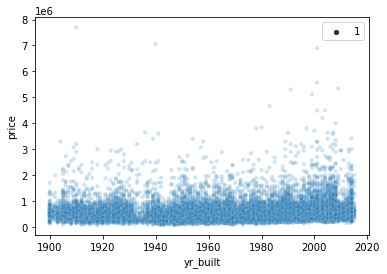

In [103]:
sns.scatterplot(data=df, x='yr_built', y='price', size=1, alpha=0.2);

On its own the feature is not particularly interesting. There is a slight increase in price as the age of the home decreases.

It's likely the case we will use this feature to engineer other, more interesting features.

## 'yr_renovated'

There are some null values in this feature we saw at import that we will need to decide what to do with.

In [104]:
df.yr_renovated.value_counts(normalize=True)

0.0       0.958096
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1948.0    0.000056
1951.0    0.000056
1971.0    0.000056
1934.0    0.000056
1944.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

Over 95% of homes in our dataset have a value of 0.0, meaning the home has never been renovated. We assume that the null values are homes not renovated and set the value to 0.0

In [105]:
df['yr_renovated'].fillna(0.0, inplace=True)

It would be interesting to see the relationship between year built and year renovated, so we leave feature in for now.

It may be the case that we separate out the feature into one that is a numerical boolean (which makes sense, because 96% of homes have not been renovated).

It may also be the case that we not consider a home renovated if the renovation took place years before the home sale. It looks like there are some homes which were renovated in the 1930s and 1940s, they should not be considered renovated now.

Some early research shows that to be considered 'renovations' it should have occurred within 15 years, so we may use that information to make more features about renovation status.

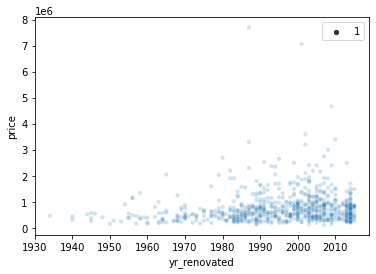

In [107]:
sns.scatterplot(data=df[df.yr_renovated > 0], x='yr_renovated', y='price',
                size=1, alpha=0.2);

We can see the density homes being renovated increases as our relative distance from sale decreases. As mentioned above, it's not honest to count a home as renovated if the renovations occur more than 15 years before the sale.

For baseline we will just leave it be, but likely need to engineer a feature to better represent if a home is renovated or not.

## 'zipcode'

In [108]:
df.zipcode.value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

There are 70 different zip codes in the county. Even the smallest zipcodes have 50 homes sold in the year our data was collected. 

If we are going to use zipcode data, we will need to convert it in some way. It may be worthwhile to look at converting zip codes into cities and look at the data collectively that way, the same with the 4 regions we learned about during research. For now, we will just add 'zipcode' to the features-to-drop list and engineer a solution after baseline modeling

In [109]:
features_to_drop.extend(['zipcode'])

In [ ]:
# biggest_zip = int(df.zipcode.value_counts().index[0])
# biggest_zip = 'zip_' + str(biggest_zip)

In [ ]:
# # import OHE
# from sklearn.preprocessing import OneHotEncoder

# # create temporary dataframe df_test with zipcode feature in it
# df_test = df[['zipcode']].copy()

# # create a onehotencoder, fit to df_test
# ohe = OneHotEncoder().fit(df_test)

# # create the array
# onehotarray = ohe.transform(df_test).toarray()

# # create a list of the sorted zipcodes to make column names
# ordered_zipcodes = sorted(list(df.zipcode.unique()))

# column_names = []
# # generate column_names to match values, 'zip_{zipcode}'
# for x in ordered_zipcodes:
#     column_names.append(f'zip_{x}')

# # create dataframe of array with correct column names
# ohe_df = pd.DataFrame(onehotarray, columns=column_names)

# # remove the column representing the most frequent value zipcode
# ohe_df.drop([biggest_zip], axis=1, inplace=True)

# # concat the main dataframe df with the onehotencoded df we just made
# df = pd.concat([df, ohe_df], axis=1)

# # add the original feature to the features to be dropped list
# features_to_drop.extend(['zipcode'])

## 'lat'

In [110]:
df.lat.describe()

count    21597.000000
mean        47.560093
std          0.138552
min         47.155900
25%         47.471100
50%         47.571800
75%         47.678000
max         47.777600
Name: lat, dtype: float64

Latitude goes from 47.155900 to 47.777600

We may use this in modeling, but no processing needed.

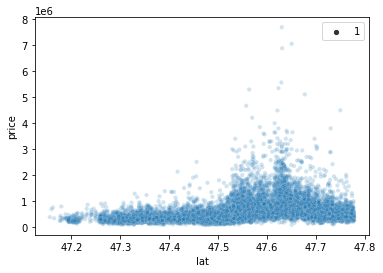

In [111]:
sns.scatterplot(data=df, x='lat', y='price', size=1, alpha=0.2);

There does seem to be some kind of relationship here, as the latitude goes up (we go north from the southern edge of the county), price tends to increase. This makes sense from our mapping in EDA, as we saw Seattle and its suburbs start around 47.5 degrees latitude.

## 'long'

In [112]:
df.long.describe()

count    21597.000000
mean      -122.213982
std          0.140724
min       -122.519000
25%       -122.328000
50%       -122.231000
75%       -122.125000
max       -121.315000
Name: long, dtype: float64

Longitude goes from -122.519000 to -121.315000.

Combined with 'lat' we can plot the locations of our our sold homes on a map and look for patterns

In terms of modeling, EDA showed that this feature is not very correlated with price

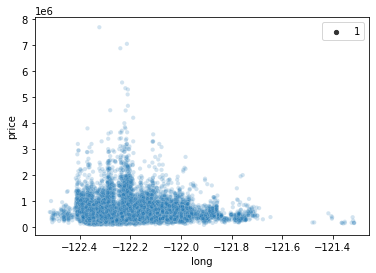

In [113]:
sns.scatterplot(data=df, x='long', y='price', size=1, alpha=0.2);

As we saw in mapping, as we go west in the county (decrease our longitude) we see most of our home. There was not very much correlation here, and that makes sense because the geography of the county restricts most development to the western part. Once you are in the better longitude, there is variation moving north and south that we saw in latitude.

## 'sqft_living15'

In [114]:
df.sqft_living15.describe()

count    21597.000000
mean      1986.620318
std        685.230472
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64

Per the data notes, these values are the square footage of interior housing living space for the nearest 15 neighbors. It looks to already be an average value, we do not need to engineer anything.

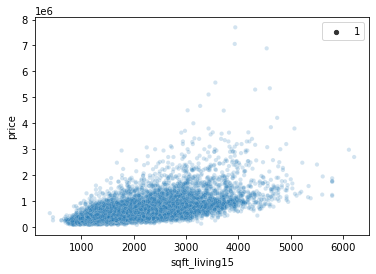

In [115]:
sns.scatterplot(data=df, x='sqft_living15', y='price', alpha=0.2, size=1);

There looks to be a slight relationship between the size of homes around the particular home and the sale price. We will see how the baseline model reacts to the data. It did show higher correlation from the matrix, but we do suspect multicollinearity.

## 'sqft_lot15'

In [116]:
df.sqft_lot15.describe()

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64

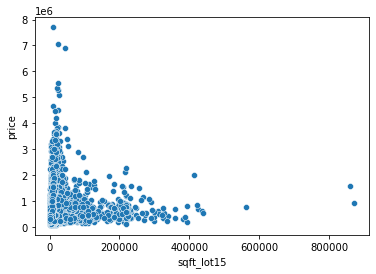

In [117]:
sns.scatterplot(data=df, x='sqft_lot15', y='price');

Again, based on data notes and experience with the dataset (and values from the other 'sqft_lot' feature), these values are the average lot for the 15 nearest neighbors to the property.

During EDA we saw there was barely any correlation between this feature and price. The plot of this feature with price doesn't seem to be linear, so on it's own the feature is likely not going to help the model.

What it may help us do is categorize neighborhoods, or create a feature where the home is more likely to be around homes of similar sizes.

In [118]:
# just in case we need to revert to original dropped features list
# features_to_drop = ['id', 'date', 'price', 'view', zipcode']

# Baseline model

In [119]:
def model_evaluation(X, y):
    """
    This helper function sets up a linear regression model, evaluates the r^2
    score and reports on the features' coefficients and p-values, and any
    recommendations for removal based on p-value or multicollinearity.
    
    It takes in an already created X (set of predictors) and y (target). This
    way the function can be used before and after test_train_splits or any
    scaling or other preprocessing
    
    It prints the adjusted r2 score from the model, and gives a brief on any
    features to be removed based on their coefficients' high p-value.
    
    It also creates a table of VIF scores for features relative o 
    """

    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()

    print('r^2 adjusted score:', model.rsquared_adj, '\n')

    predictors = pd.DataFrame([])
    predictors['coeff'] = model.params
    predictors['pvalue'] = model.pvalues
    
    print('Predictors where coefficient pvalue is > 0.05:')
    if len(predictors[predictors.pvalue > 0.05]) > 0:
        print(list(predictors[predictors.pvalue > 0.05].index))
    else:
        print('0')

#     old test for multicollinearity
#     testmc_df = X.corr().abs().stack().reset_index().sort_values(0,ascending=False)
#     testmc_df['pairs'] = list(zip(testmc_df.level_0, testmc_df.level_1))
#     testmc_df.set_index(['pairs'], inplace=True)
#     testmc_df.drop(['level_0', 'level_1'], axis=1, inplace=True)
#     testmc_df.columns = ['mc']
#     print('\nCases of multicollinearity:')
#     if len(testmc_df[(testmc_df.mc > 0.75) & (testmc_df.mc < 1)]) > 0:
#         display(testmc_df[(testmc_df.mc > 0.75) & (testmc_df.mc < 1)])
#     else:
#         print('0')

    # inner function to calculate VIF for features relative to target
    # to check for multicollinearity.
    def calc_vif(X):
        vif = pd.DataFrame()
        vif['variables'] = X.columns
        vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        return(vif)
    
    # create the VIG table for predictors, to be returned by function
    vif = calc_vif(X)

    return model, predictors, vif   # old test return: testmc_df

Our baseline model is all predictors with the exception of: id, date, and zipcode.

In [120]:
X = df.drop(features_to_drop, axis=1)
y = df.price

bl_model, predictors, vif = model_evaluation(X, y)

r^2 adjusted score: 0.6942537595595895 

Predictors where coefficient pvalue is > 0.05:
['floors']


In [121]:
bl_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     2886.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        09:18:19   Log-Likelihood:            -2.9459e+05
No. Observations:               21597   AIC:                         5.892e+05
Df Residuals:                   21579   BIC:                         5.894e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.683e+07    1.6e+06    -23.005      0.000      -4e+07   -3.37e+07
bedrooms      -3.807e+04   1995.793    -19.076      0.000    -4.2e+04   -3.42e+04
bathrooms      4.379e+04   3297.643     13.279      0.000    3.73e+04    5.03e+04
sqft_living     100.7294     18.249      5.520      0.000      64.961     136.498
sqft_lot          0.1311      0.048      2.710      0.007       0.036       0.226
floors         1740.0219   3617.663      0.481      0.631   -5350.866    8830.910
waterfront     6.972e+05   1.75e+04     39.828      0.000    6.63e+05    7.31e+05
condition      3.158e+04   2353.406     13.419      0.000     2.7e+04    3.62e+04
grade           9.86e+04   2179.680     45.234      0.000    9.43e+04    1.03e+05
sqft_above       80.3181     18.237      4.404      0.000      44.572     116.064
sqft_basement    50.6676     18.073      2.804      0.005      15.244      86.091
yr_built      -2502.6709     72.055    -34.733      0.000   -2643.903   -2361.438
yr_renovated     25.2837      4.013      6.300      0.000      17.417      33.150
lat            5.551e+05   1.06e+04     52.503      0.000    5.34e+05    5.76e+05
long          -1.197e+05    1.2e+04     -9.936      0.000   -1.43e+05   -9.61e+04
sqft_living15    28.3567      3.470      8.172      0.000      21.555      35.158
sqft_lot15       -0.4004      0.074     -5.408      0.000      -0.546      -0.255
has_view       1.073e+05   5232.578     20.499      0.000     9.7e+04    1.18e+05
==============================================================================
Omnibus:                    18422.014   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1818110.030
Skew:                           3.594   Prob(JB):                         0.00
Kurtosis:                      47.371   Cond. No.                     5.86e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Checking assumptions

Many of our assumptions require us have the residuals for the model. We will create a helper function to get the residuals to use in checking our assumptions for linear regression.

In [ ]:
# # helper function that takes three arguments: a linear regression model,
# # a dataframe of test predictors, and a dataframe of the test target variable.
# # It then returns a dataframe of the residuals based on calculated predictions

# def residuals(model, predictors, target):
    
#     # calculate predicted values from model
#     y_hat = model.predict(predictors)
    
#     # create dataframe with the target (real) and predicted values
#     df_residuals = pd.DataFrame({'real': target, 'predicted': y_hat})
    
#     # create a new feature of that dataframe 'residuals', which is the
#     # difference of the real the the predicted
#     df_residuals['residuals'] = (abs(df_residuals.real) - abs(df_residuals.predicted))
    
#     return df_residuals

The relationship is not terrible, the model does not perform well as price increases, but that's expected, we have not changed our data and have few high priced homes to train on. This gives us more cause to consider removing outliers from some features, like sqft_living and/or price.

### Independence

In [ ]:
sm.graphics.plot_regress_exog()

In [ ]:
bl_model.resid.mean()

In [ ]:
testing_df = pd.DataFrame()
testing_df['resid'] = bl_model.resid
testing_df['predicted'] = pd.Series(bl_model.predict())

In [ ]:
sns.scatterplot(data=testing_df, x='resid', y='predicted',
               alpha=0.2);

### Normality

Check the distribution of the residuals, using a histogram and/or QQ plot. Can also be checked with Kolmogorov-Smirnov test.

In [ ]:
sns.histplot(data=testing_df, x='resid');

In [ ]:
testing_df

### Homoskedacity

In [ ]:
sm.qqplot(testing_df.predicted, line='q')

In [ ]:
sns.scatterplot(x=testing_df.resid, y=testing_df.resid,
               size=1, alpha=0.2)
plt.plot(np.repeat(0, testing_df.index.max()), color='darkorange',
         linestyle='--');

## Exploring coefficient p-values

Now we can pull out all features whose coefficients' p-value was greater than the threshold (0.05)
_______
We will add these features to our features-to-drop list and work on engineering later

In [122]:
features_to_drop.extend(list(predictors[predictors.pvalue > 0.05].index))

In [123]:
features_to_drop

['id', 'date', 'price', 'view', 'zipcode', 'floors']

## Identify multicollinearity

Using a VIF cutoff value of 5, it's easier to look at variables below (for inclusion) than above.

In [124]:
vif[vif.VIF<5]

,variables,VIF
3,sqft_lot,2.362915
5,waterfront,1.084047
11,yr_renovated,1.149723
15,sqft_lot15,2.581323
16,has_view,1.395925


In [125]:
vif[vif.VIF>5]

,variables,VIF
0,bedrooms,25.370848
1,bathrooms,28.781497
2,sqft_living,900.809434
4,floors,16.750671
6,condition,34.528871
7,grade,142.881225
8,sqft_above,674.560903
9,sqft_basement,47.021961
10,yr_built,8382.411042
12,lat,119893.803485


We already suspected that sqft_above and sqft_basement would experience multicollinearity, so we will drop those. As well as yr_built, lat, and long.

In [126]:
features_to_drop.extend(['sqft_above', 'sqft_basement', 'yr_built', 'lat',
                         'long'])

# Model v1 - dropping features

We have been keeping track of features to drop so far:
- based on the p-value of the coefficient from the OLS baseline model and
- the test for multicollinearity that was performed

In [127]:
X = df.drop(features_to_drop, axis=1)
y = df.price

model_v1, predictors, vif = model_evaluation(X, y)

r^2 adjusted score: 0.6104786486871583 

Predictors where coefficient pvalue is > 0.05:
['sqft_lot']


In [128]:
features_to_drop.extend(['sqft_lot'])

In [129]:
X = df.drop(features_to_drop, axis=1)
y = df.price

model_v1, predictors, vif = model_evaluation(X, y)

r^2 adjusted score: 0.6104939511751579 

Predictors where coefficient pvalue is > 0.05:
0


In [133]:
predictors.sort_values('pvalue')

,coeff,pvalue
const,-710604.961532,0.000000e+00
sqft_living,197.195142,0.000000e+00
grade,99195.148056,0.000000e+00
waterfront,686867.116238,4.412542e-258
condition,60999.797075,1.735607e-133
has_view,138082.841431,1.367025e-128
yr_renovated,77.662052,1.923213e-71
bedrooms,-38068.124380,3.351659e-64
sqft_lot15,-0.755290,1.303922e-37
bathrooms,-16398.042167,5.078640e-07


In [131]:
vif

,variables,VIF
0,bedrooms,22.130113
1,bathrooms,22.170253
2,sqft_living,24.251814
3,waterfront,1.082496
4,condition,19.857795
5,grade,54.697208
6,yr_renovated,1.050496
7,sqft_living15,25.189791
8,sqft_lot15,1.283251
9,has_view,1.291564


Condition and grade are still high, as is sqft_living15, bedrooms and bathrooms.

In [134]:
features_to_drop.extend(['bedrooms', 'bathrooms', 'grade', 'sqft_living15'])

In [135]:
X = df.drop(features_to_drop, axis=1)
y = df.price

model_v1, predictors, vif = model_evaluation(X, y)

r^2 adjusted score: 0.5584738688580286 

Predictors where coefficient pvalue is > 0.05:
0


In [137]:
vif

,variables,VIF
0,sqft_living,5.562175
1,waterfront,1.077604
2,condition,5.027036
3,yr_renovated,1.045177
4,sqft_lot15,1.262210
5,has_view,1.257327


In [138]:
model_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     4554.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        09:28:20   Log-Likelihood:            -2.9856e+05
No. Observations:               21597   AIC:                         5.971e+05
Df Residuals:                   21590   BIC:                         5.972e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -1.6e+05   9931.157    -16.109      0.000   -1.79e+05   -1.41e+05
sqft_living    263.9801      1.915    137.878      0.000     260.227     267.733
waterfront    7.054e+05    2.1e+04     33.623      0.000    6.64e+05    7.47e+05
condition     3.944e+04   2567.886     15.360      0.000    3.44e+04    4.45e+04
yr_renovated    66.3027      4.595     14.429      0.000      57.296      75.309
sqft_lot15      -0.7058      0.062    -11.388      0.000      -0.827      -0.584
has_view      1.667e+05   5988.154     27.839      0.000    1.55e+05    1.78e+05
==============================================================================
Omnibus:                    13395.001   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           476890.381
Skew:                           2.432   Prob(JB):                         0.00
Kurtosis:                      25.501   Cond. No.                     3.81e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We have pruned features from our model based on VIF score, adding them to the 'features-to-drop' running list. Out r2 score is not great at 55, so now we need to work on engineering new features from the ones we dropped to improve the model

# Model v2 - removing outliers

**HOLDING OFF ON REMOVING OUTLIERS**

During EDA we saw through boxplotting and further analysis there were outliers in the price, sqft_living, and sqft_lot features. We will identify and remove those homes from the dataset and see if our model becomes more accurate at predicting price for a normal home.

In [ ]:
upper_limit_price

In [ ]:
# df_v2 = df[df.price <= upper_limit_price].copy()
# df_v2 = df_v2[df_v2.sqft_living <= upper_limit_sqft_living].copy()
# df_v2 = df_v2[df_v2.sqft_lot <= upper_limit_sqft_lot].copy()
# df_v2.reset_index(drop=True, inplace=True)

# outlier_percent = round(((len(df) - len(df_v2)) / len(df))*100, 2)

# print(f'Outliers from price, sqft_living, and sqft_lot constituted\
#  {outlier_percent}% of our dataset')

In [ ]:
# predictors, testmc_df = model_evaluation(df_v2, features_to_drop)

# Feature Engineering

Other than 'date' and 'price', these are the features dropped through the first two OLS linear regression models due to multicollinearity and/or high coefficient p-values. On their own these features do not help predict the price of a home, but perhaps we can use the information to engineer new features that will.

We will be copying the dataframe df_v2 for use in all these feature engineering sections. This dataframe is the result of the removal of outliers from the original dataframe based on three features: price, sqft_living, and sqft_lot. We can easily change this in step six by reassigning df_v2 to a copy of the regular dataframe not stripped of outliers.

In [139]:
df_v2 = df.copy()

In [140]:
sorted(features_to_drop)

['bathrooms',
 'bedrooms',
 'date',
 'floors',
 'grade',
 'id',
 'lat',
 'long',
 'price',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot',
 'view',
 'yr_built',
 'zipcode']

## Model v3 - rooms

The number of bedrooms and bathrooms must be important to cost. There are some other ways of thinking about how the rooms relate to the rest of the home, and what else you can say about the features of that home.

In [141]:
room_features = df_v2[['price','sqft_living','bedrooms',
                           'bathrooms']].copy()

One idea is to look at the the number of bedrooms and bathrooms per square foot and see if that has any relationship to price.

In [142]:
room_features['bath_per_ft2'] = room_features.bathrooms/room_features.sqft_living
room_features['bed_per_ft2'] = room_features.bedrooms/room_features.sqft_living

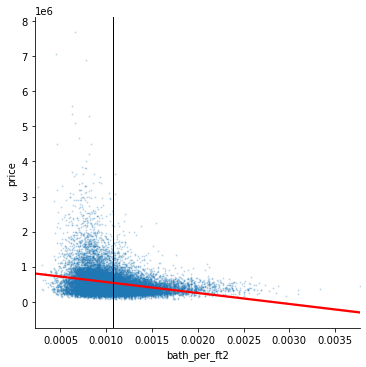

In [146]:
sns.lmplot(data=room_features, x='bath_per_ft2', y='price',
           line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=room_features.bath_per_ft2.mean(), color='black', lw=1,
            label='Avg');

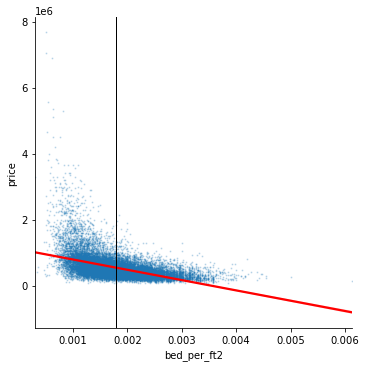

In [147]:
sns.lmplot(data=room_features, x='bed_per_ft2', y='price',
           line_kws={'color':'red'},
           scatter_kws={'s':1,'alpha':0.2})
plt.axvline(x=room_features.bed_per_ft2.mean(), color='black', lw=1,
            label='Avg');

It seems that as the density for either room increases, price tends to decrease. If we think about this, there gets to be a point at which there would be too many bedrooms or bathrooms and not enough space in the rest of the home to enjoy.
___________________
Research shows that the ratio of bedrooms to bathrooms in a home is generally at 3:2. Using this information, we will see if there is anything interesting in the data. The data for bathroom count is a float, we are going to look at two interpretations: one where the bathrooms is rounded to the next whole number, and one where it is not.

In [148]:
#rounding up bathrooms
def bathbedratio(df):
    expected_bathrooms = math.ceil(df.bedrooms*(2/3))
    if math.ceil(df.bathrooms) > expected_bathrooms:
        return 1
    elif math.ceil(df.bathrooms) < expected_bathrooms:
        return -1
    elif math.ceil(df.bathrooms) == expected_bathrooms:
        return 0
    
#not rounding up    
def nrbathbedratio(df):
    expected_bathrooms = df.bedrooms*(2/3)
    if df.bathrooms > expected_bathrooms:
        return 1
    elif df.bathrooms < expected_bathrooms:
        return -1
    elif df.bathrooms == expected_bathrooms:
        return 0

In [149]:
room_features['bathbedratio'] = room_features.apply(lambda x: bathbedratio(x), axis=1)
room_features['nrbathbedratio'] = room_features.apply(lambda x: nrbathbedratio(x), axis=1)

In [150]:
room_features.bathbedratio.value_counts(normalize=True)

 0    0.433486
-1    0.302959
 1    0.263555
Name: bathbedratio, dtype: float64

In [151]:
room_features.nrbathbedratio.value_counts(normalize=True)

-1    0.585174
 1    0.365792
 0    0.049035
Name: nrbathbedratio, dtype: float64

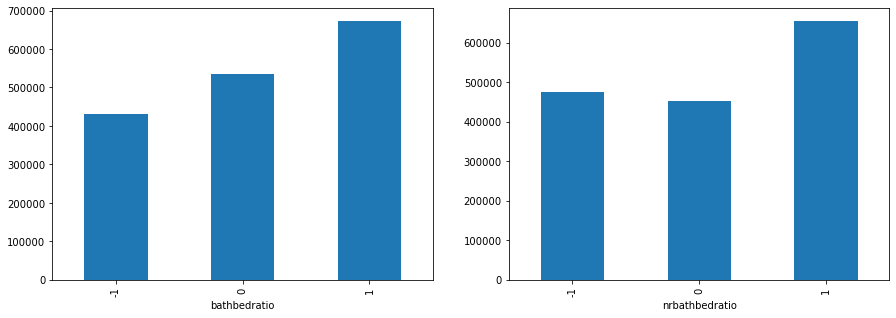

In [152]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
room_features.groupby('bathbedratio').mean()['price'].plot(kind='bar', ax=ax[0])
room_features.groupby('nrbathbedratio').mean()['price'].plot(kind='bar', ax=ax[1]);

Rounding up to the next integer for bathroom count shows that 43.7% of homes meet the 3:2 ratio, 25.2% exceed it, and 31.1% don't meet it. So about 2/3 meet or exceed when rounding up. Additionally, the average price goes up as we move from not meeting to meeting to exceeding the ratio.

If we don't round the bathroom value up to the nearest integer, the majority of the previously matched ratio homes are now counted as below the ratio. 59.8% now do not meet the ratio, 35.2% exceed it, and only 5% match exactly

Not rounding there is a positive difference in price between exceeding and failing to meet the ratio, but the price drops from failing to meet to meeting.


>We could try modeling with the range of -1 to 1 values for rounding.

>Additionally, we could make a new binary feature from the non-rounding feature. There doesn't seem to be too much of a difference in meeting exactly or not meeting the ratio, but there is a large jump to exceeding.

In [153]:
room_features['exceedbbr'] = room_features.nrbathbedratio.map(lambda x: 1 if x == 1 else 0)

In [154]:
df_v2['bath_per_ft2'] = room_features.bath_per_ft2
df_v2['bed_per_ft2'] = room_features.bed_per_ft2
df_v2['bedbathratio'] = room_features.bathbedratio
df_v2['exceedbbr'] = room_features.exceedbbr

In [158]:
X = df_v2.drop(features_to_drop, axis=1)
y = df_v2.price

model_v3, predictors, vif = model_evaluation(X,y)

r^2 adjusted score: 0.5635534443670296 

Predictors where coefficient pvalue is > 0.05:
0


In [159]:
vif

,variables,VIF
0,sqft_living,6.725137
1,waterfront,1.078874
2,condition,20.703497
3,yr_renovated,1.051372
4,sqft_lot15,1.267050
5,has_view,1.275520
6,bath_per_ft2,31.103414
7,bed_per_ft2,31.690708
8,bedbathratio,3.850662
9,exceedbbr,4.043641


Neither of the square footage features seemed appropriate, but both the bedbathratio and the exceedbbr features are below our threshold. For now we will keep bedbathratio

In [160]:
features_to_drop.extend(['bed_per_ft2', 'bath_per_ft2', 'exceedbbr'])

## Model v4 - actual living space

The only room information we have on room count is bedrooms and bathrooms, but we can use that and make some extrapolations.

[Research](https://www.thespruce.com/average-kitchen-size-1822119#:~:text=Typically%2C%20a%20kitchen%20occupies%2010,include%20homes%20of%20all%20ages)
shows the in the United States there is generally an owners bedroom and then standard bedrooms. The average owner's room is 224 ft${^2}$ the average standard bedroom is 132 ft${^2}$. We will assume the one bedroom in each home is an owners room and the remaining bedrooms are standard when calculating sizes.

Average bathroom size is more difficult. The bathroom feature is a value composed of an unknown combination of bathroom types. Bathrooms can be a variety of square footage depending on components and purpose. Since the data we have is not whole number of bathrooms, we are going to use a coefficient we found during [research](https://www.homestratosphere.com/average-size-bathroom/) that the average bathroom size is 40 ft${^2}$. This way partial baths will be counted a bit smaller and should be more accurate for total square footage of all bathrooms in the home.


We can also say that every home needs a kitchen. [Researching](https://www.thespruce.com/average-kitchen-size-1822119#:~:text=Typically%2C%20a%20kitchen%20occupies%2010,include%20homes%20of%20all%20ages) average kitchen size in the United States shows that this varies based on the size of the home, but there is a generally agreed upon percentage of 10-15% total square footage; we will split the difference and use 12.5%.


There are no additional assumptions we could make other than to subtract all these figures from total square footage and that would give us a figure of actual living space in the home. That space may be made up of multiple other rooms, like a separate family/sitting room, formal dining, office, etc. But at least we can account for how much of the total home can be used for everyday activities and guests, and we will call that sqft_entertain

In [161]:
def living_area(df):
    area = df.sqft_living
    
    # total bedroom sqft, first bedroom is 224, all others 132
    bedrooms = 224 + ((df.bedrooms-1)*132)
    
    # total bathroom sqft
    bathrooms = 40*df.bathrooms
    
    # approximate kitchen sqft
    kitchen = area * .125
    
    return area-(bedrooms+bathrooms+kitchen)

In [162]:
space_features = df_v2[['price','sqft_living','bedrooms','bathrooms']].copy()

In [163]:
space_features['sqft_entertain'] = space_features.apply(lambda x: living_area(x), axis=1)

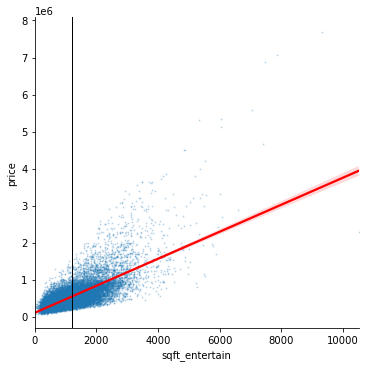

In [177]:
sns.lmplot(data=space_features, x='sqft_entertain', y='price',
           scatter_kws={'alpha':0.2, 's':1},
           line_kws={'color':'red'})
plt.axvline(x=space_features.sqft_entertain.mean(), color='black', lw=1,
            label='Avg');

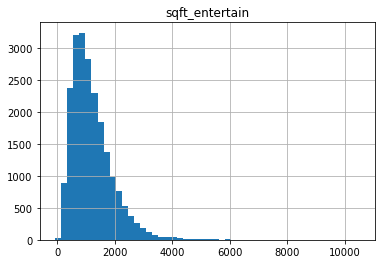

In [165]:
space_features.hist(column='sqft_entertain', bins=50);

In [166]:
space_features.sqft_entertain.describe()

count    21597.000000
mean      1198.569529
std        716.474009
min        -89.250000
25%        689.500000
50%       1046.625000
75%       1544.375000
max      10511.500000
Name: sqft_entertain, dtype: float64

Definitely a relationship between this new measure of square footage in the home to price. BUT we do have some negative values

In [167]:
space_features[space_features.sqft_entertain <= 0]

,price,sqft_living,bedrooms,bathrooms,sqft_entertain
1166,290000.0,440,2,0.75,-1.00
4199,150000.0,490,3,0.75,-89.25


We will have to come back to these
_______
Maybe if we instead look at it as a percentage of total home that will be more revealing.

In [168]:
space_features['percent_entertain'] = space_features.sqft_entertain/space_features.sqft_living

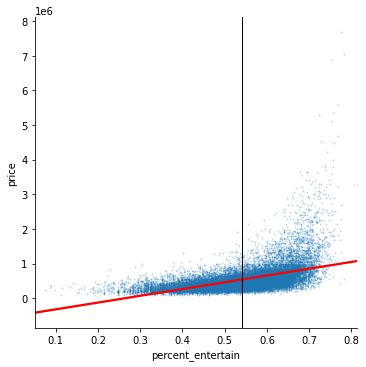

In [179]:
sns.lmplot(data=space_features[space_features.percent_entertain > 0],
           x='percent_entertain', y='price',
           scatter_kws={'alpha':0.2, 's':1},
           line_kws={'color':'red'})
plt.axvline(x=space_features.percent_entertain.mean(), color='black', lw=1,
            label='Avg');

In [170]:
space_features.percent_entertain.describe()

count    21597.000000
mean         0.541946
std          0.098231
min         -0.182143
25%          0.480970
50%          0.551046
75%          0.613365
max          0.812719
Name: percent_entertain, dtype: float64

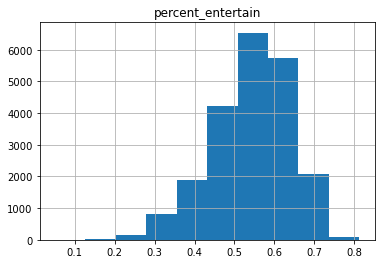

In [171]:
space_features[space_features.percent_entertain > 0].hist(column='percent_entertain', bins=10);

There were two very tiny homes who's engineered features were below zero. Here we instead just set them equal to 0.

In [172]:
space_features.at[1166, ['sqft_entertain','percent_entertain']] = 0
space_features.at[4199, ['sqft_entertain','percent_entertain']] = 0

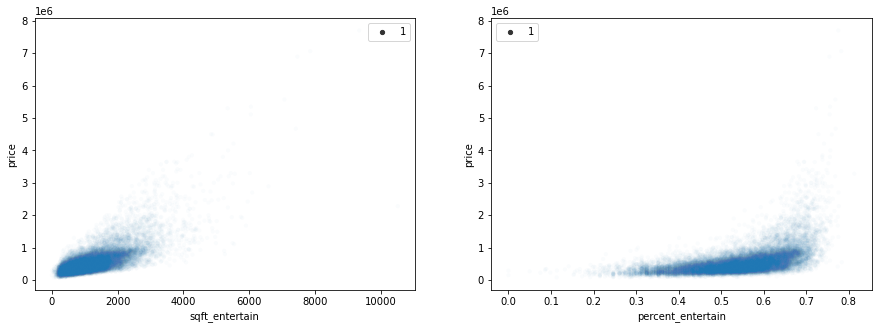

In [182]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.scatterplot(data=space_features, x='sqft_entertain', y='price',
                alpha=0.02, size=1, ax=ax[0])
sns.scatterplot(data=space_features, x='percent_entertain', y='price',
                alpha=0.02, size=1, ax=ax[1]);

_______
We could also look at average room size. If we know how many bathrooms and bedrooms there are, and we know there is at least 1 kitchen and 1 common/living area, we could take the total square footage and divide by that number and get average room square footage. For larger homes with more than 1 common area (like a family room, den, sunroom) our estimate will be higher, but maybe that will be ok

In [176]:
space_features['avg_room_size'] = space_features.sqft_living/(space_features.bedrooms + space_features.bathrooms + 2)

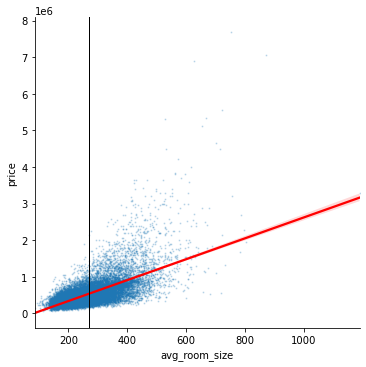

In [183]:
sns.lmplot(data=space_features, x='avg_room_size', y='price',
           scatter_kws={'alpha':0.2, 's':1},
           line_kws={'color':'red'})
plt.axvline(x=space_features.avg_room_size.mean(), color='black', lw=1,
            label='Avg');

___________

In [184]:
df_v2['sqft_entertain'] = space_features.sqft_entertain
df_v2['percent_entertain'] = space_features.percent_entertain
df_v2['avg_room_size'] = space_features.avg_room_size

In [185]:
X = df_v2.drop(features_to_drop, axis=1)
y = df_v2.price

model_v4, predictors, vif = model_evaluation(X, y)

r^2 adjusted score: 0.5981106683875911 

Predictors where coefficient pvalue is > 0.05:
0


In [186]:
model_v4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     3215.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        09:39:46   Log-Likelihood:            -2.9754e+05
No. Observations:               21597   AIC:                         5.951e+05
Df Residuals:                   21586   BIC:                         5.952e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              6.854e+05   2.13e+04     32.217      0.000    6.44e+05    7.27e+05
sqft_living        -410.0898     16.759    -24.470      0.000    -442.938    -377.241
waterfront         6.551e+05   2.01e+04     32.615      0.000    6.16e+05    6.94e+05
condition          4.827e+04   2485.471     19.419      0.000    4.34e+04    5.31e+04
yr_renovated         67.9734      4.386     15.497      0.000      59.376      76.571
sqft_lot15           -0.8386      0.060    -14.066      0.000      -0.955      -0.722
has_view           1.515e+05   5738.708     26.392      0.000     1.4e+05    1.63e+05
bedbathratio      -8117.1659   2741.651     -2.961      0.003   -1.35e+04   -2743.327
sqft_entertain     1165.1820     28.463     40.937      0.000    1109.393    1220.971
percent_entertain -5.073e+05   4.47e+04    -11.342      0.000   -5.95e+05    -4.2e+05
avg_room_size     -2188.5456    105.722    -20.701      0.000   -2395.768   -1981.323
==============================================================================
Omnibus:                     9235.127   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           178594.221
Skew:                           1.578   Prob(JB):                         0.00
Kurtosis:                      16.730   Cond. No.                     8.67e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [188]:
predictors.sort_values('pvalue')

,coeff,pvalue
sqft_entertain,1165.181953,0.000000e+00
waterfront,655118.189540,8.256270e-228
const,685356.292679,1.867249e-222
has_view,151457.538864,4.183264e-151
sqft_living,-410.089752,1.836875e-130
avg_room_size,-2188.545644,2.795782e-94
condition,48266.315308,2.719279e-83
yr_renovated,67.973426,7.140839e-54
sqft_lot15,-0.838555,9.690067e-45
percent_entertain,-507287.018893,9.810011e-30


In [189]:
vif

,variables,VIF
0,sqft_living,306.799159
1,waterfront,1.084710
2,condition,25.983576
3,yr_renovated,1.050925
4,sqft_lot15,1.281490
5,has_view,1.282327
6,bedbathratio,1.686669
7,sqft_entertain,319.788189
8,percent_entertain,209.560226
9,avg_room_size,317.329546


The model didn't improve that much, and really all we did was create multicollinearity with 'sqft_living'. We will not use these features

In [190]:
features_to_drop.extend(['sqft_entertain','percent_entertain','avg_room_size'])

## Model v5 - renovation

Set up new dataframe 'renovation_features' to hold engineered features before joining in with original features.

We are first working on the renovation status, so we will need some features: yr_built, yr_renovated, and sale_year

In [191]:
renovation_features = df_v2[['price', 'yr_built', 'yr_renovated', 'date']].copy()

During research on renovations, it seems like a general industry standard is that a home is considered renovated if the renovation took place within 15 years. We are engineering a new feature 'is_renovated' as a boolean, with 1 being the home is renovated within 15 years of sale, and 0 being either never renovated or renovations took place more than 15 years before sale.

In [192]:
def renovation_status(df):
    if df.yr_renovated == 0.0:
        return 0
    else:
        if (df.date.year - df.yr_renovated) > 15:
            return 0
        else:
            return 1

renovation_features['is_renovated'] = renovation_features.apply(renovation_status, axis=1)

In [193]:
renovation_features.is_renovated.value_counts()

0    21206
1      391
Name: is_renovated, dtype: int64

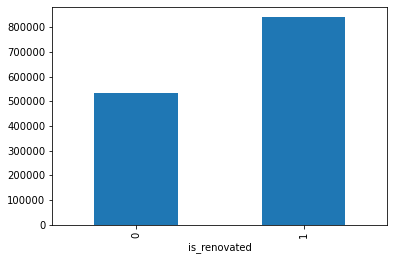

In [194]:
renovation_features.groupby('is_renovated').mean()['price'].plot(kind='bar');

Our renovation feature is now a boolean representing homes that were renovated with 15 years of the sale. There is a definite difference in average price of a renovated home versus one that is not.

In [195]:
df_v2['is_renovated'] = renovation_features.is_renovated

In [196]:
features_to_drop.extend(['yr_renovated'])

In [197]:
X = df_v2.drop(features_to_drop, axis=1)
y = df_v2.price

model_v5, predictors, vif = model_evaluation(X,y)

r^2 adjusted score: 0.5600602286756773 

Predictors where coefficient pvalue is > 0.05:
0


In [198]:
vif

,variables,VIF
0,sqft_living,6.257902
1,waterfront,1.074842
2,condition,5.723437
3,sqft_lot15,1.262934
4,has_view,1.254523
5,bedbathratio,1.148520
6,is_renovated,1.023309


In [199]:
model_v5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     3929.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        09:40:32   Log-Likelihood:            -2.9852e+05
No. Observations:               21597   AIC:                         5.971e+05
Df Residuals:                   21589   BIC:                         5.971e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -1.61e+05   9913.044    -16.238      0.000    -1.8e+05   -1.42e+05
sqft_living    259.5344      2.004    129.519      0.000     255.607     263.462
waterfront    7.187e+05   2.09e+04     34.365      0.000    6.78e+05     7.6e+05
condition     4.277e+04   2597.365     16.468      0.000    3.77e+04    4.79e+04
sqft_lot15      -0.6925      0.062    -11.190      0.000      -0.814      -0.571
has_view      1.688e+05   5969.498     28.277      0.000    1.57e+05     1.8e+05
bedbathratio  1.497e+04   2360.843      6.341      0.000    1.03e+04    1.96e+04
is_renovated  1.968e+05   1.25e+04     15.749      0.000    1.72e+05    2.21e+05
==============================================================================
Omnibus:                    13625.159   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           508179.717
Skew:                           2.479   Prob(JB):                         0.00
Kurtosis:                      26.241   Cond. No.                     3.81e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model v6 - basement

The sqft_basement poses some interesting questions. I think first we want a column to see if there is a basement or not

In [200]:
basement_features = df_v2[['price', 'sqft_living', 'sqft_basement']].copy()

In [201]:
basement_features['has_basement'] = basement_features.sqft_basement.map(
    lambda x: 1 if x > 0 else 0)

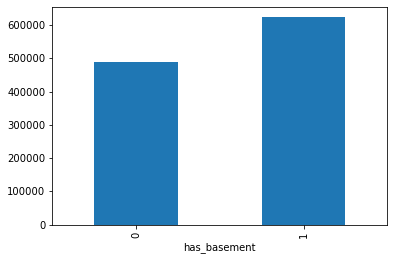

In [202]:
basement_features.groupby('has_basement').mean()['price'].plot(kind='bar');

Definitely a difference in average price by if a basement exists or not.

In [203]:
def percent_basement(df):
    if df.has_basement == False:
        return 0
    else:
        return round(((df.sqft_basement / df.sqft_living) * 100), 2)

In [204]:
basement_features['basement_percent'] = basement_features.apply(
    percent_basement, axis=1)

In [205]:
basement_features[basement_features.basement_percent > 0
                 ].basement_percent.describe()

count    8317.000000
mean       31.688273
std        11.567126
min         1.000000
25%        23.140000
50%        32.210000
75%        40.780000
max        66.670000
Name: basement_percent, dtype: float64

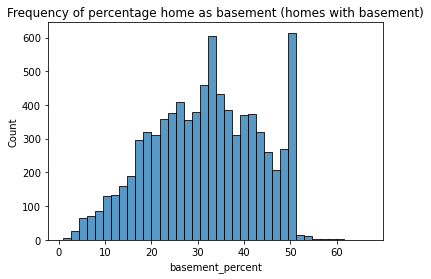

In [206]:
sns.histplot(data=basement_features[basement_features.basement_percent > 0
                                   ], x='basement_percent')
plt.title('Frequency of percentage home as basement (homes with basement)');

In our dataset, 60% of homes have no basement at all.

Of those that have basements, the above histogram shows the binned percent of sqft_living that is made up of sqft_basement.

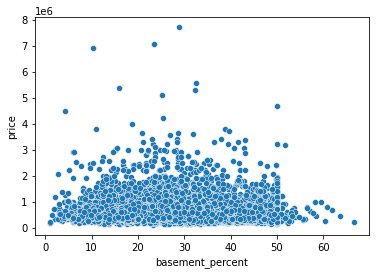

In [207]:
sns.scatterplot(data=basement_features[basement_features.basement_percent > 0],
                x='basement_percent', y='price');

There does not look to be any kind of linear relationship with the percentage basement and price. We would likely just use the boolean 'has_basement'

In [208]:
df_v2['has_basement'] = basement_features.has_basement

In [209]:
X = df_v2.drop(features_to_drop, axis=1)

model_v6, predictors, vif = model_evaluation(X, y)

r^2 adjusted score: 0.560041369222028 

Predictors where coefficient pvalue is > 0.05:
['has_basement']


In [210]:
vif

,variables,VIF
0,sqft_living,6.430793
1,waterfront,1.075053
2,condition,5.926379
3,sqft_lot15,1.272304
4,has_view,1.280516
5,bedbathratio,1.148599
6,is_renovated,1.025172
7,has_basement,1.774426


In [211]:
model_v6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     3437.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        09:41:14   Log-Likelihood:            -2.9852e+05
No. Observations:               21597   AIC:                         5.971e+05
Df Residuals:                   21588   BIC:                         5.971e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.611e+05   9933.827    -16.222      0.000   -1.81e+05   -1.42e+05
sqft_living    259.6320      2.035    127.553      0.000     255.642     263.622
waterfront    7.186e+05   2.09e+04     34.356      0.000    6.78e+05     7.6e+05
condition     4.287e+04   2623.076     16.345      0.000    3.77e+04     4.8e+04
sqft_lot15      -0.6939      0.062    -11.172      0.000      -0.816      -0.572
has_view       1.69e+05   6025.351     28.052      0.000    1.57e+05    1.81e+05
bedbathratio  1.497e+04   2360.971      6.339      0.000    1.03e+04    1.96e+04
is_renovated  1.969e+05   1.25e+04     15.744      0.000    1.72e+05    2.21e+05
has_basement  -973.8605   3566.591     -0.273      0.785   -7964.642    6016.921
==============================================================================
Omnibus:                    13622.864   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           507837.840
Skew:                           2.479   Prob(JB):                         0.00
Kurtosis:                      26.233   Cond. No.                     3.81e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model v7 - zipcode

In [212]:
zipcode_features = df_v2[['price', 'zipcode']].copy()

There at 70 different zipcode values in our dataset. We want to try and create a new feature that takes zipcodes and matches them up with cities in our area.

In [213]:
# https://zipdatamaps.com/king-wa-county-zipcodes
zip_city = pd.read_csv('data\zip_city.csv')

zipcode_features = pd.merge(left=zipcode_features, right=zip_city, on='zipcode', how='left')

zipcode_features can be merged into the larger dataframe to associate a home with a city instead of just a zipcode.

Let's explore this a bit more.

In [214]:
homes_by_zip = zipcode_features.groupby('city').count()
homes_by_zip.drop('price', axis=1, inplace=True)
homes_by_zip.reset_index(inplace=True)

In [215]:
homes_by_zip.sort_values('zipcode', ascending=False)

,city,zipcode
20,Seattle,8973
18,Renton,1597
1,Bellevue,1407
11,Kent,1201
12,Kirkland,977
17,Redmond,977
0,Auburn,911
19,Sammamish,800
8,Federal Way,779
9,Issaquah,733


We could reduce our 70 zipcodes to 24 cities we could then OneHotEncode. It's no surprise that Seattle dominates the frequency listing of cities in the data, it's the largest city in the state, let alone the county.
_________
The [website](https://www.communitiescount.org/king-county-geographies) where we found the region information listed the names of cities each region defined. We created lists for each of the regions first, then had to check if we had any cities in our data that were not mentioned on the website and assign them correctly

In [216]:
north = ['Bothell', 'Kenmore', 'Woodinville']
east = ['Bellevue', 'Carnation', 'Duvall', 'Issaquah', 'Kirkland', 'Medina',
        'Mercer Island', 'North Bend', 'Redmond', 'Sammamish']
south = ['Auburn', 'Enumclaw', 'Federal Way', 'Kent', 'Maple Valley',
         'Renton', 'Vashon']

In [217]:
region_cities = sorted(north + east + south)
data_cities = sorted(list(homes_by_zip.city))

missing_cities = []
for city in data_cities:
    if city not in region_cities:
        missing_cities.append(city)
        
missing_cities

['Black Diamond', 'Fall City', 'Seattle', 'Snoqualmie']

Seattle will be its own region, but we had to do a bit of map checking to place the three cities we had from our zipcode mapping that were not mentioned on the website discussing the 4 regions of the county.

In [218]:
south.extend(['Black Diamond'])
east.extend(['Fall City', 'Snoqualmie'])

In [219]:
def assignRegion(df):
    if df.city == 'Seattle':
        return 'Seattle'
    elif df.city in north:
        return 'north'
    elif df.city in east:
        return 'east'
    else:
        return 'south'

zipcode_features['region'] = zipcode_features.apply(assignRegion, axis=1)

In [220]:
zipcode_features

,price,zipcode,city,region
0,221900.0,98178,Seattle,Seattle
1,538000.0,98125,Seattle,Seattle
2,180000.0,98028,Kenmore,north
3,604000.0,98136,Seattle,Seattle
4,510000.0,98074,Sammamish,east
...,...,...,...,...
21592,360000.0,98103,Seattle,Seattle
21593,400000.0,98146,Seattle,Seattle
21594,402101.0,98144,Seattle,Seattle
21595,400000.0,98027,Issaquah,east


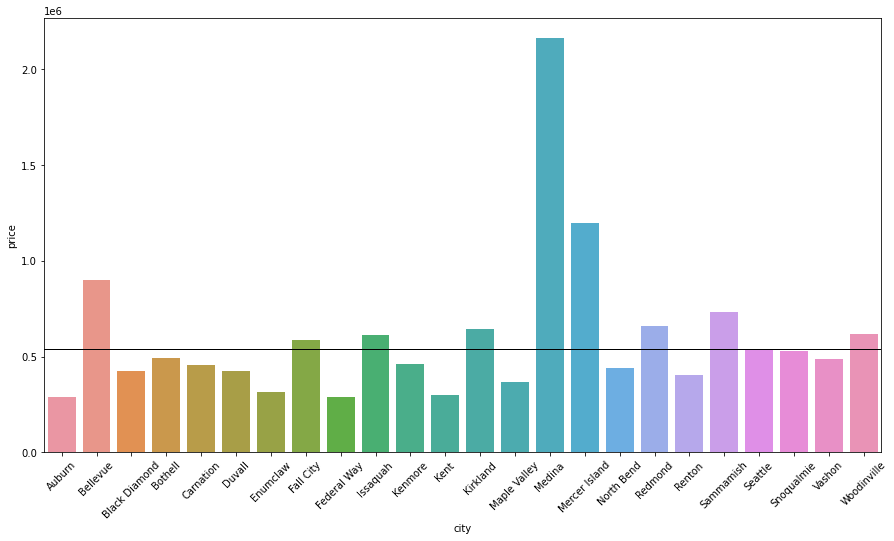

In [221]:
zipcode_city_df = zipcode_features.groupby('city').mean()[['price']]
zipcode_city_df.reset_index(inplace=True)

plt.figure(figsize = (15,8))
ax = sns.barplot(data=zipcode_city_df, x='city', y='price')
plt.axhline(y=df.price.mean(), color='black', lw=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

We can see a definite range in average home prices based on the city the home is in, from \\$281k in Auburn to over \\$2 million in Medina.

Seattle looks like it's right on our total average for home prices in our data, again endorsing the plan to drop that new encoded feature.

Some quick research shows that Medina is not only desirable for King County, but is one of the most desirable neighborhoods in the nation. There is apparently a very high concentration of millionaires. We saw earlier that only 50 homes in our data were in Medina.

Mercer Island is just sound of Medina and is also in high demand, shown by the average home prices. There were several times more homes in our data from Mercer Island compared to Medina, yet the average price is still quite high, more than double the county average.

Bellevue seems like it would be another wealthy area. There were about 1400 homes from that city in our data and the average price there was not quite double the county average.

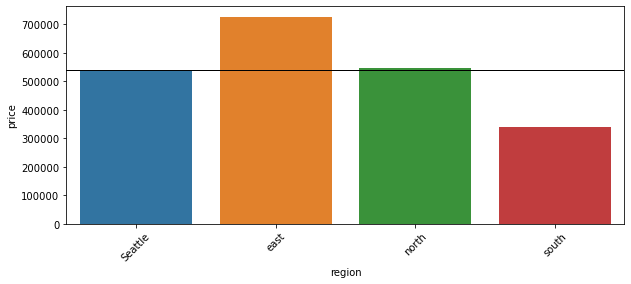

In [222]:
zipcode_region_df = zipcode_features.groupby('region').mean()[['price']]
zipcode_region_df.reset_index(inplace=True)

plt.figure(figsize = (10,4))
ax = sns.barplot(data=zipcode_region_df, x='region', y='price')
plt.axhline(y=df.price.mean(), color='black', lw=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Here it looks like average home prices based on region has a clear winner in the east region. Seattle and the north region are both pretty even with county average (and each other), and the south regions' average price is less than half that of the easts'.

If we wanted to try a different way of modeling here, it would likely not be OneHotEncoding but a binary feature if the home was in the east region or not. We will try using cities first

-------------
First we will onehotencode the cities and drop Seattle

In [223]:
# import OHE
from sklearn.preprocessing import OneHotEncoder

# create temporary dataframe city_encode with zipcode feature in it
city_encode = zipcode_features[['city']].copy()

# create a onehotencoder, fit to city_encode
ohe = OneHotEncoder().fit(city_encode)

# create the array
onehotarray = ohe.transform(city_encode).toarray()

# create a list of the sorted zipcodes to make column names
ordered_cities = sorted(list(zipcode_features.city.unique()))

# create dataframe of array with correct column names
ohe_df = pd.DataFrame(onehotarray, columns=ordered_cities)

# remove the feature for Seattle
ohe_df.drop(['Seattle'], axis=1, inplace=True)

# concat the main dataframe df with the onehotencoded df we just made
df_v3 = pd.concat([df_v2, ohe_df], axis=1)

In [224]:
df_v3

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,Maple Valley,Medina,Mercer Island,North Bend,Redmond,Renton,Sammamish,Snoqualmie,Vashon,Woodinville
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,NONE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,NONE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,NONE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,NONE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,NONE,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,NONE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,NONE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,NONE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,NONE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
X = df_v3.drop(features_to_drop, axis=1)
y = df.price

model_v7, predictors, vif = model_evaluation(X, y)

r^2 adjusted score: 0.6899624870083865 

Predictors where coefficient pvalue is > 0.05:
['sqft_lot15']


We're not suprised there is multicollinearity here. The value for sqft_lot15 is the average lot size for the 15 closest homes. Neighborhoods would tend to have similar sized lots.

In [226]:
features_to_drop.extend(['sqft_lot15'])

In [227]:
X = df_v3.drop(features_to_drop, axis=1)
y = df.price

model_v7, predictors, vif = model_evaluation(X, y)

r^2 adjusted score: 0.6899767271108856 

Predictors where coefficient pvalue is > 0.05:
0


In [228]:
model_v7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     1603.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        09:41:59   Log-Likelihood:            -2.9473e+05
No. Observations:               21597   AIC:                         5.895e+05
Df Residuals:                   21566   BIC:                         5.898e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.554e+04   8561.248     -2.983      0.003   -4.23e+04   -8757.540
sqft_living     247.5250      1.827    135.454      0.000     243.943     251.107
waterfront     7.121e+05   1.77e+04     40.150      0.000    6.77e+05    7.47e+05
condition      3.523e+04   2238.431     15.740      0.000    3.08e+04    3.96e+04
has_view       1.273e+05   5163.387     24.649      0.000    1.17e+05    1.37e+05
bedbathratio    3.08e+04   2012.415     15.307      0.000    2.69e+04    3.47e+04
is_renovated   1.302e+05   1.06e+04     12.335      0.000    1.09e+05    1.51e+05
has_basement  -4.594e+04   3139.132    -14.635      0.000   -5.21e+04   -3.98e+04
Auburn        -2.822e+05   7218.603    -39.094      0.000   -2.96e+05   -2.68e+05
Bellevue       1.336e+05   6076.782     21.991      0.000    1.22e+05    1.46e+05
Black Diamond -1.983e+05   2.06e+04     -9.616      0.000   -2.39e+05   -1.58e+05
Bothell       -1.432e+05   1.49e+04     -9.630      0.000   -1.72e+05   -1.14e+05
Carnation     -1.621e+05   1.86e+04     -8.731      0.000   -1.98e+05   -1.26e+05
Duvall        -1.975e+05   1.51e+04    -13.077      0.000   -2.27e+05   -1.68e+05
Enumclaw      -2.698e+05   1.37e+04    -19.728      0.000   -2.97e+05   -2.43e+05
Fall City      -9.75e+04    2.3e+04     -4.234      0.000   -1.43e+05   -5.24e+04
Federal Way   -2.856e+05   7680.205    -37.188      0.000   -3.01e+05   -2.71e+05
Issaquah      -7.787e+04   8049.972     -9.673      0.000   -9.36e+04   -6.21e+04
Kenmore       -1.485e+05   1.24e+04    -11.989      0.000   -1.73e+05   -1.24e+05
Kent          -2.693e+05   6401.369    -42.067      0.000   -2.82e+05   -2.57e+05
Kirkland       1.406e+04   6952.070      2.023      0.043     437.060    2.77e+04
Maple Valley  -2.575e+05   8906.419    -28.909      0.000   -2.75e+05    -2.4e+05
Medina         1.075e+06   2.92e+04     36.769      0.000    1.02e+06    1.13e+06
Mercer Island  2.633e+05   1.26e+04     20.880      0.000    2.39e+05    2.88e+05
North Bend    -1.686e+05    1.4e+04    -12.014      0.000   -1.96e+05   -1.41e+05
Redmond       -4.295e+04   7149.195     -6.008      0.000    -5.7e+04   -2.89e+04
Renton        -2.067e+05   5691.754    -36.323      0.000   -2.18e+05   -1.96e+05
Sammamish     -7.218e+04   7900.695     -9.136      0.000   -8.77e+04   -5.67e+04
Snoqualmie    -2.111e+05   1.21e+04    -17.487      0.000   -2.35e+05   -1.87e+05
Vashon        -2.476e+05   1.93e+04    -12.832      0.000   -2.85e+05    -2.1e+05
Woodinville   -1.053e+05   9857.341    -10.686      0.000   -1.25e+05    -8.6e+04
==============================================================================
Omnibus:                    15920.069   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1061933.962
Skew:                           2.941   Prob(JB):         

## Model v8 - distance from city center

Was having difficulty importing Geopy in the learn-env, so there is a separate notebook 'geopy' where I import the data and then calculate the distance from the city center of Seattle to the home in miles.

In [229]:
distance_df = pd.read_csv('data\distances.csv', index_col=[0])

In [230]:
df_v3['d_from_seattle'] = distance_df.d_from_seattle

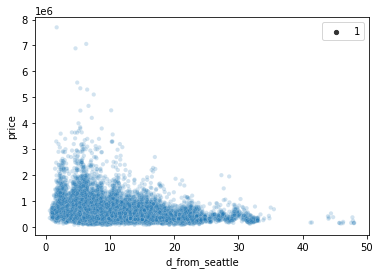

In [231]:
sns.scatterplot(data=df_v3, x='d_from_seattle', y='price', alpha=0.2, size=1);

In [232]:
X = df_v3.drop(features_to_drop, axis=1)
y = df.price

model_v8, predictors, vif = model_evaluation(X, y)

r^2 adjusted score: 0.7281468573661771 

Predictors where coefficient pvalue is > 0.05:
['Bothell', 'Kenmore', 'Vashon']


The only predictors with multicollinearity are the onehotencoded cities, which we do not drop.

In [234]:
vif

,variables,VIF
0,sqft_living,7.895595
1,waterfront,1.098239
2,condition,10.280103
3,has_view,1.341276
4,bedbathratio,1.188172
5,is_renovated,1.032359
6,has_basement,1.980693
7,Auburn,2.537491
8,Bellevue,1.274437
9,Black Diamond,1.230128


Including this feature did improve the score, but there is some multicollinearity. One idea would be to multiply the square footage by the distance from the city center for a new feature

In [235]:
df_v3['sqftxdistfrsea'] = df_v3.sqft_living * df_v3.d_from_seattle

In [236]:
features_to_drop.extend(['d_from_seattle'])

In [237]:
X = df_v3.drop(features_to_drop, axis=1)
y = df.price

model_v8, predictors, vif = model_evaluation(X, y)

r^2 adjusted score: 0.7586177591667826 

Predictors where coefficient pvalue is > 0.05:
['Bothell']


In [239]:
model_v8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     2190.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        09:46:32   Log-Likelihood:            -2.9203e+05
No. Observations:               21597   AIC:                         5.841e+05
Df Residuals:                   21565   BIC:                         5.844e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -9.011e+04   7599.129    -11.858      0.000   -1.05e+05   -7.52e+04
sqft_living      399.7497      2.525    158.289      0.000     394.800     404.700
waterfront      7.191e+05   1.56e+04     45.951      0.000    6.88e+05     7.5e+05
condition       2.182e+04   1982.555     11.007      0.000    1.79e+04    2.57e+04
has_view        1.126e+05   4559.939     24.684      0.000    1.04e+05    1.21e+05
bedbathratio    2.385e+04   1777.932     13.415      0.000    2.04e+04    2.73e+04
is_renovated    7.039e+04   9342.364      7.534      0.000    5.21e+04    8.87e+04
has_basement   -7.394e+04   2792.879    -26.474      0.000   -7.94e+04   -6.85e+04
Auburn          9.433e+04   7980.380     11.821      0.000    7.87e+04     1.1e+05
Bellevue        1.601e+05   5372.640     29.793      0.000     1.5e+05    1.71e+05
Black Diamond   2.832e+05   1.92e+04     14.746      0.000    2.46e+05    3.21e+05
Bothell        -9092.9098   1.32e+04     -0.687      0.492    -3.5e+04    1.68e+04
Carnation        2.42e+05   1.72e+04     14.094      0.000    2.08e+05    2.76e+05
Duvall          1.494e+05    1.4e+04     10.639      0.000    1.22e+05    1.77e+05
Enumclaw        3.395e+05   1.44e+04     23.651      0.000    3.11e+05    3.68e+05
Fall City       2.835e+05   2.09e+04     13.571      0.000    2.43e+05    3.25e+05
Federal Way     6.873e+04   8148.373      8.435      0.000    5.28e+04    8.47e+04
Issaquah        1.618e+05   7734.181     20.917      0.000    1.47e+05    1.77e+05
Kenmore        -3.923e+04    1.1e+04     -3.561      0.000   -6.08e+04   -1.76e+04
Kent            1.335e+04   6702.894      1.992      0.046     212.485    2.65e+04
Kirkland        6.964e+04   6175.273     11.277      0.000    5.75e+04    8.17e+04
Maple Valley    1.399e+05   9354.510     14.956      0.000    1.22e+05    1.58e+05
Medina          8.747e+05   2.59e+04     33.740      0.000    8.24e+05    9.26e+05
Mercer Island   1.788e+05   1.12e+04     15.988      0.000    1.57e+05    2.01e+05
North Bend      4.098e+05   1.44e+04     28.416      0.000    3.81e+05    4.38e+05
Redmond         1.272e+05   6671.897     19.063      0.000    1.14e+05     1.4e+05
Renton          -7.44e+04   5298.948    -14.040      0.000   -8.48e+04    -6.4e+04
Sammamish       1.394e+05   7476.665     18.647      0.000    1.25e+05    1.54e+05
Snoqualmie       2.74e+05   1.23e+04     22.238      0.000     2.5e+05    2.98e+05
Vashon         -4.028e+04   1.72e+04     -2.338      0.019    -7.4e+04   -6508.566
Woodinville     1.259e+05   9185.359     13.707      0.000    1.08e+05    1.44e+05
sqftxdistfrsea   -13.2315      0.169    -78.318      0.000     -13.563     -12.900
==============================================================================
Omnibus:                    12877.922   Durbin-Watson:                   1.990
Prob(Omnibus):      

## Model v9 - home quality: multiplying condition/grade

In [240]:
df_v3['home_quality'] = df_v3.condition * df_v3.grade

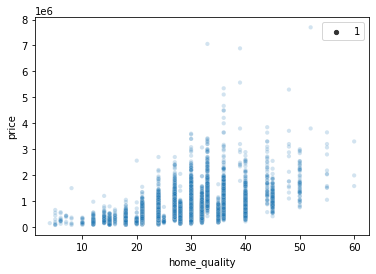

In [241]:
sns.scatterplot(data=df_v3, x='home_quality', y='price', size=1, alpha=0.2);

In [242]:
home_quality = df_v3.groupby('home_quality').mean()[['price']]

In [243]:
home_quality.reset_index(inplace=True)

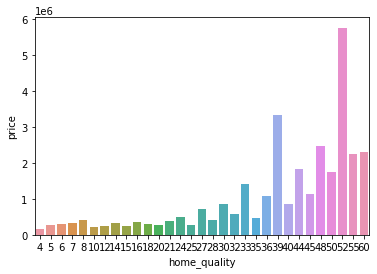

In [244]:
sns.barplot(data=home_quality, x='home_quality', y='price');

In [250]:
features_to_drop.extend(['condition'])

In [251]:
X = df_v3.drop(features_to_drop, axis=1)
y = df_v3.price

model_v9, predictors, vif = model_evaluation(X, y)

r^2 adjusted score: 0.7674285253439614 

Predictors where coefficient pvalue is > 0.05:
['Bothell', 'Kent']


In [252]:
model_v9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     2300.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        09:48:40   Log-Likelihood:            -2.9163e+05
No. Observations:               21597   AIC:                         5.833e+05
Df Residuals:                   21565   BIC:                         5.836e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.666e+05   6102.051    -27.298      0.000   -1.79e+05   -1.55e+05
sqft_living      374.7742      2.618    143.167      0.000     369.643     379.905
waterfront      7.191e+05   1.54e+04     46.816      0.000    6.89e+05    7.49e+05
has_view        1.049e+05   4483.913     23.394      0.000    9.61e+04    1.14e+05
bedbathratio     1.98e+04   1728.164     11.458      0.000    1.64e+04    2.32e+04
is_renovated     8.79e+04   9174.280      9.581      0.000    6.99e+04    1.06e+05
has_basement   -7.244e+04   2723.411    -26.600      0.000   -7.78e+04   -6.71e+04
Auburn          8.761e+04   7826.491     11.194      0.000    7.23e+04    1.03e+05
Bellevue        1.434e+05   5299.581     27.055      0.000    1.33e+05    1.54e+05
Black Diamond   2.745e+05   1.88e+04     14.566      0.000    2.38e+05    3.11e+05
Bothell        -5950.5627    1.3e+04     -0.458      0.647   -3.14e+04    1.95e+04
Carnation       2.465e+05   1.69e+04     14.626      0.000    2.14e+05     2.8e+05
Duvall          1.564e+05   1.38e+04     11.346      0.000    1.29e+05    1.83e+05
Enumclaw        3.204e+05   1.41e+04     22.769      0.000    2.93e+05    3.48e+05
Fall City       2.842e+05   2.05e+04     13.860      0.000    2.44e+05    3.24e+05
Federal Way     5.877e+04   8002.965      7.344      0.000    4.31e+04    7.45e+04
Issaquah        1.522e+05   7598.919     20.027      0.000    1.37e+05    1.67e+05
Kenmore        -3.668e+04   1.08e+04     -3.392      0.001   -5.79e+04   -1.55e+04
Kent            6353.9719   6571.037      0.967      0.334   -6525.748    1.92e+04
Kirkland        6.732e+04   6061.078     11.107      0.000    5.54e+04    7.92e+04
Maple Valley    1.391e+05   9179.646     15.157      0.000    1.21e+05    1.57e+05
Medina          8.653e+05   2.54e+04     34.001      0.000    8.15e+05    9.15e+05
Mercer Island   1.534e+05    1.1e+04     13.943      0.000    1.32e+05    1.75e+05
North Bend      4.025e+05   1.42e+04     28.431      0.000    3.75e+05     4.3e+05
Redmond         1.236e+05   6550.018     18.875      0.000    1.11e+05    1.36e+05
Renton          -7.68e+04   5192.411    -14.791      0.000    -8.7e+04   -6.66e+04
Sammamish       1.297e+05   7345.469     17.663      0.000    1.15e+05    1.44e+05
Snoqualmie      2.793e+05   1.21e+04     23.091      0.000    2.56e+05    3.03e+05
Vashon         -4.722e+04   1.69e+04     -2.794      0.005   -8.03e+04   -1.41e+04
Woodinville     1.141e+05   9025.206     12.644      0.000    9.64e+04    1.32e+05
sqftxdistfrsea   -12.8211      0.166    -77.115      0.000     -13.147     -12.495
home_quality    7559.6204    246.213     30.704      0.000    7077.025    8042.215
==============================================================================
Omnibus:                    13933.228   Durbin-Watson:                   1.988
Prob(Omnibus):      

In [253]:
vif

,variables,VIF
0,sqft_living,23.823275
1,waterfront,1.097294
2,has_view,1.338865
3,bedbathratio,1.112578
4,is_renovated,1.042334
5,has_basement,1.957779
6,Auburn,1.726530
7,Bellevue,1.251563
8,Black Diamond,1.125565
9,Bothell,1.042873


## Model v10 - very good condition or not

In [254]:
df_v3['condition_5'] = df_v3.condition.map(lambda x: 1 if x == 5 else 0)

In [255]:
X = df_v3.drop(features_to_drop, axis=1)
y = df_v3.price

model_v10, predictors, vif = model_evaluation(X, y)

r^2 adjusted score: 0.7691498066900803 

Predictors where coefficient pvalue is > 0.05:
['Bothell', 'Kent']


In [256]:
vif

,variables,VIF
0,sqft_living,25.093949
1,waterfront,1.097486
2,has_view,1.339021
3,bedbathratio,1.113044
4,is_renovated,1.043262
5,has_basement,1.958439
6,Auburn,1.741402
7,Bellevue,1.255766
8,Black Diamond,1.126383
9,Bothell,1.044437


## Floors -> Lot Use

Started to explore this, initially it looks like we might be able to classify some of our homes as townhomes, and maybe that will help improve the model.

In [ ]:
# lot_use_df = df_v2[['price','sqft_living','floors','sqft_lot']].copy()

The footprint of the home would be the sqft_living divided by floors. We can then compare this to sqft_lot and see how much of a yard the home actually has.

In [ ]:
# lot_use_df['footprint'] = df_v2.sqft_living / df_v2.floors

In [ ]:
# lot_use_df.footprint.describe()

In [ ]:
# lot_use_df.groupby('floors').mean()['footprint']

The [typical townhome layout](https://www.simpletwig.com/blog/the-ultimate-townhouse-layout/#:~:text=The%20design%20challenge%20is%20to,lost%20space%20in%20public%20areas.) is a footprint of 20'x45', or 900 ft${^2}$. 

In [ ]:
# sorted(list(lot_use_df.floors.unique()))

In [ ]:
# for floor in sorted(list(lot_use_df.floors.unique())):
    
#     sub_df = lot_use_df[lot_use_df.floors == floor].copy()
    
#     total = len(sub_df)
    
#     floorplan_under = len(sub_df[sub_df.footprint <= 900])
#     floorplan_over = len(sub_df[sub_df.footprint > 900])
    
#     print(f'Total homes with {floor} floor(s): {total}')
#     print(f'Of that, {floorplan_under} had footprints under 900 ft^2')
#     print(f'and {floorplan_over} had footprints over 900 ft^2')
#     print('\n')